In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solveStateEquation import getSourceTerm, solveStateEquation, buildControlFunction
from src.solveAdjointEquation import solveAdjointEquation
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient, integrateVectorFunction, getIdxMax
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists
from typing import List

@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    newton_c = 100
    eta = 0.01
    alpha = 1e-6
    beta = 1e-4
    waveSpeed = 2
    randomFactor = 0.00
    maxIterations = 50
    pruneThreshold = 1e-7
    yd = []
    yd_adjoint = []
    standardInnerProducts = None
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(32, 32),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

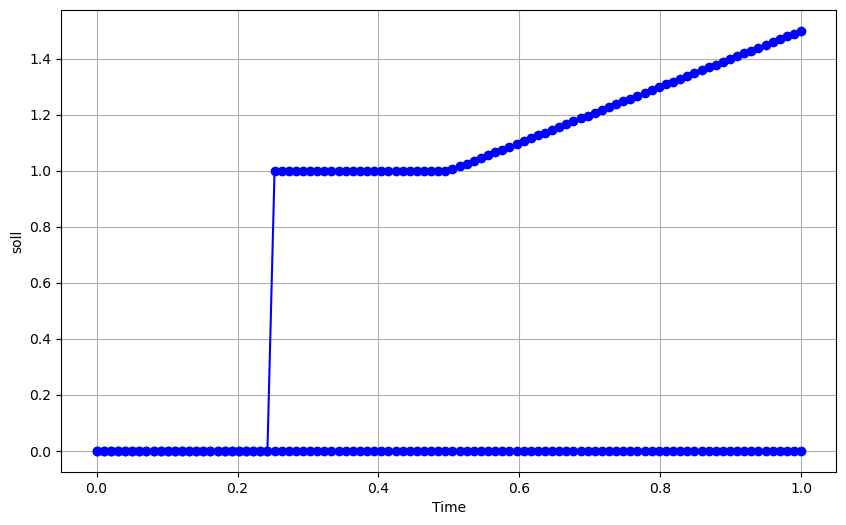

In [9]:
ext1 = ExtremalPoint(np.array([1., 0]), x_0=0.25, type=0, params=params)
ext2 = ExtremalPoint(np.array([1., 0]), x_0=0.5, type=1, params=params)
s1 = lambda t : ext1.value(t)[0] * params.alpha + ext2.value(t)[0] * params.beta#0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)) / params.alpha
s2 = lambda t : 0#0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275)) / params.alpha
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
control = buildControlFunction([g1, g2], [s1, s2], params)
K_u = solveStateEquation(control, params)
grid_size = K_u[0].x.array.shape
raw_matrices = [K_u_t.x.array for K_u_t in K_u]
norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
np.random.seed(42)
yd = [fem.Function(params.V) for _ in K_u]
for idx in range(len(yd)):
    yd[idx].x.array[:] = K_u[idx].x.array + 0*np.random.normal(loc=0.0, scale=scale, size=grid_size)
params.yd = K_u
params.yd_adjoint = solveAdjointEquation(params.yd, params)
discretInterval = np.linspace(0, params.T, int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in discretInterval])
array[:, 1] = np.array([s2(t) for t in discretInterval])
plot_array(array, params.T, label='soll')
#timeDependentVariableToGif(yd, 'output/observation.gif')

Objective upper bound:  6033287548.12854
weights:  [8.11689275e-01 7.70927673e-01 2.05227222e-01 4.45244592e-05
 4.75711088e-05 4.78358630e-05] slope:  [9.66869406 8.36381303] y_shift [21.59560784 18.18560083]
Objective:  47438097.376465246
0 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8116892749278026 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.7709276728061282 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.20522722194754336 	id: 139856754951808
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 4.452445920665101e-05 	id: 139856547469104
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 4.757110880576536e-05 	id: 139856539836080
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0 = 0.29 ,	type = 0 	weight: 4.7835862972954644e-05 	id: 139856540014720
slope:  [9.66869406 8.36381303] y_shift [21.59560784 18.18560083]
0 : Hess

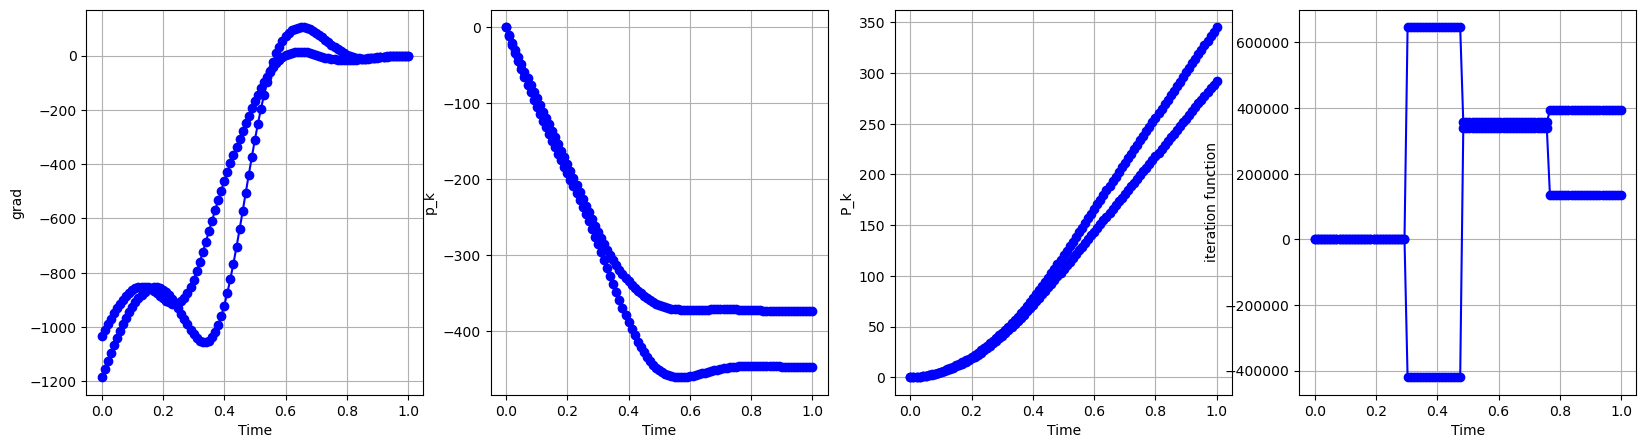

|p_max|/alpha:  591324349.9427104 , |P_max|/beta:  4466980.991030773
x_S:  0.5700000000000001 x_K:  0.99 
New point: sigma= [-0.62810608 -0.77812772] x_0 = 0.5700000000000001 , type = 0
weights:  [8.78938212e-01 8.03897361e-01 1.71999247e-01 0.00000000e+00
 8.76404514e-06 1.21225972e-05 8.64091994e-02] slope:  [12.92692556 11.82945299] y_shift [29.38316106 26.04428942]
Objective:  47001984.94321565
1 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8789382118260874 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8038973608553787 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.1719992472137789 	id: 139856754951808
	 3 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 8.764045143238163e-06 	id: 139856539836080
	 4 sigma= [ 0.41994472 -0.90754968] ,	x_0 = 0.29 ,	type = 0 	weight: 1.2122597165944901e-05 	id: 139856540014720
	 5 sigma= [-0.62810608 -0

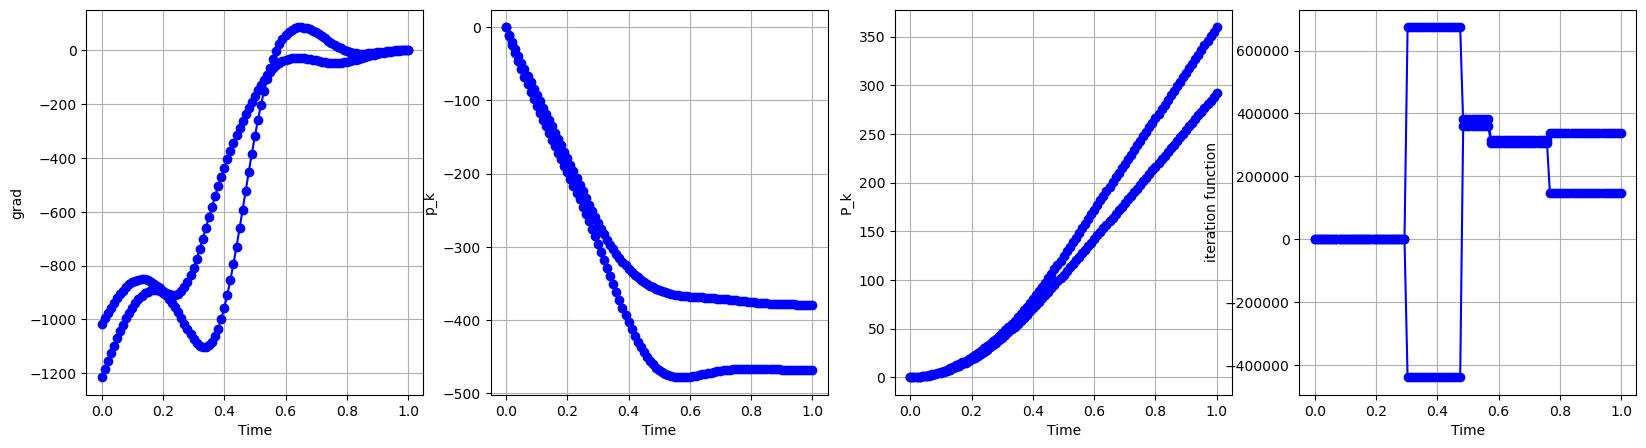

|p_max|/alpha:  602590764.8945055 , |P_max|/beta:  4572224.462378715
x_S:  0.59 x_K:  0.99 
New point: sigma= [-0.60983027 -0.79253204] x_0 = 0.59 , type = 0
weights:  [8.78754560e-01 8.03980976e-01 1.57744419e-01 4.55977288e-05
 4.57710036e-05 1.21089199e-02 8.51996434e-02] slope:  [9.81488089 8.50205186] y_shift [21.70917771 18.41501283]
Objective:  46951755.18488475
2 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8787545603278182 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.803980975628337 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15774441946180112 	id: 139856754951808
	 3 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 4.559772879732402e-05 	id: 139856539836080
	 4 sigma= [ 0.41994472 -0.90754968] ,	x_0 = 0.29 ,	type = 0 	weight: 4.577100363187797e-05 	id: 139856540014720
	 5 sigma= [-0.62810608 -0.77812772] ,	x_0 = 0.5700000000

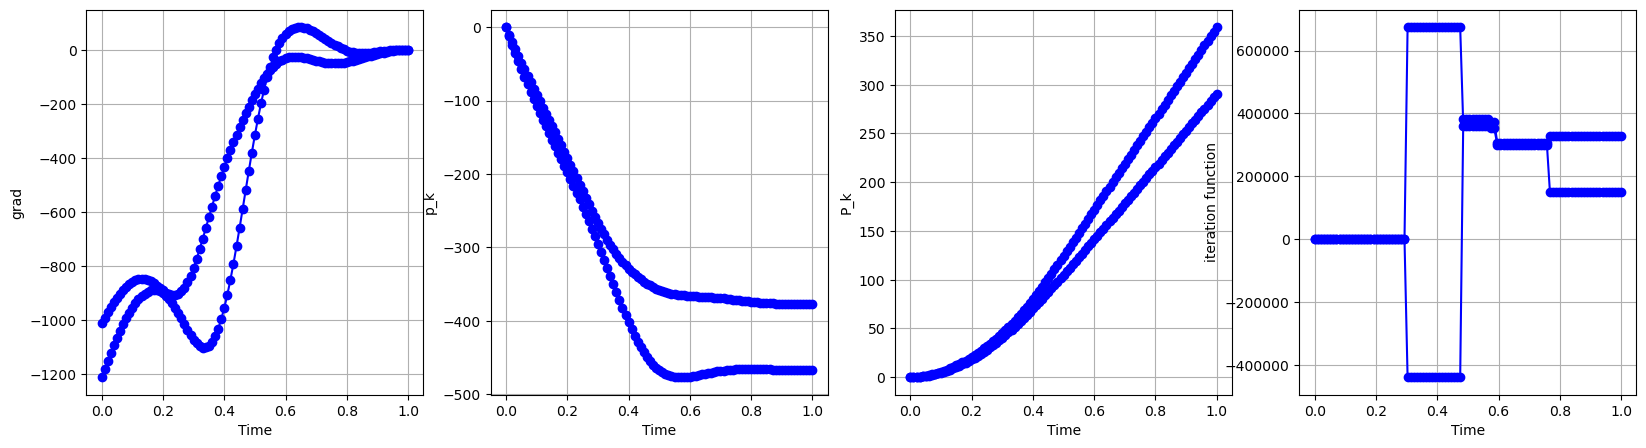

|p_max|/alpha:  600563095.1621099 , |P_max|/beta:  4559365.735002777
x_S:  0.59 x_K:  0.99 
New point: sigma= [-0.60896636 -0.79319605] x_0 = 0.59 , type = 0
weights:  [8.80903566e-01 8.05275530e-01 1.54045713e-01 0.00000000e+00
 0.00000000e+00 8.00550714e-05 5.06386235e-02 5.20820280e-02] slope:  [9.83518057 8.52076103] y_shift [21.71611928 18.44698285]
Objective:  46929893.42807543
3 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8809035660883723 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8052755295115558 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.1540457131344575 	id: 139856754951808
	 3 sigma= [-0.62810608 -0.77812772] ,	x_0 = 0.5700000000000001 ,	type = 0 	weight: 8.005507135257141e-05 	id: 139856545757856
	 4 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.050638623533584635 	id: 139856522447184
	 5 sigma= [-0.60896636 -0.79

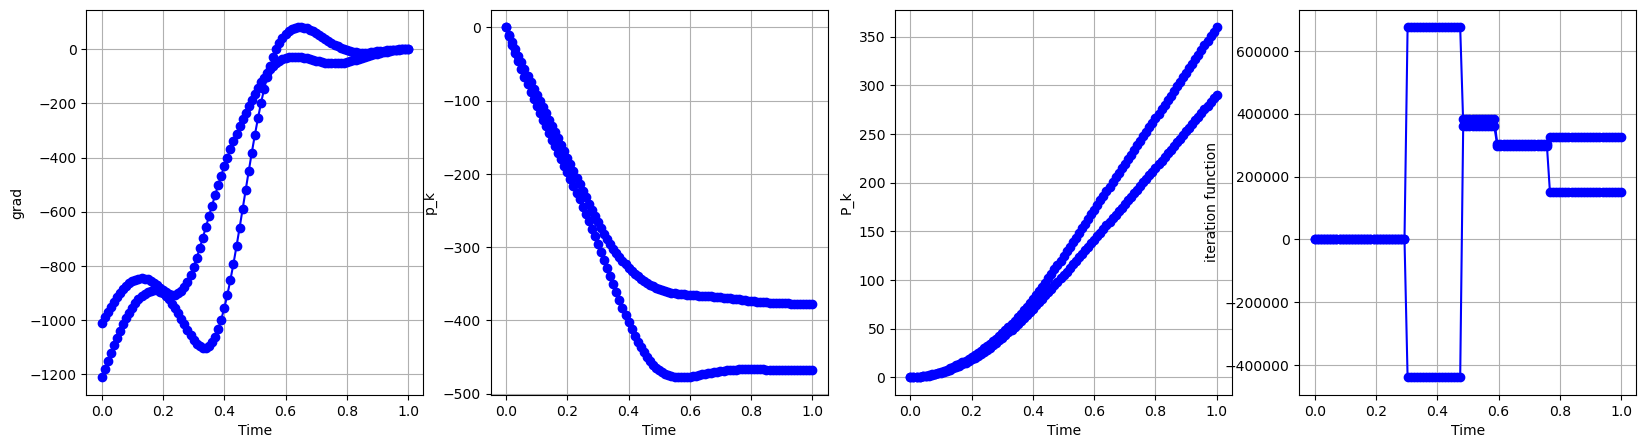

|p_max|/alpha:  601053344.5860059 , |P_max|/beta:  4561986.168467837
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62755602 -0.77857141] x_0 = 0.99 , type = 0
weights:  [8.80120179e-01 8.04713515e-01 1.55007158e-01 6.83747663e-05
 4.99935917e-02 5.14515446e-02 0.00000000e+00] slope:  [ 9.63250927 11.35770994] y_shift [21.31073692 25.77659475]
Objective:  46926260.70861791
4 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8801201789946294 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8047135145551467 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15500715833659737 	id: 139856754951808
	 3 sigma= [-0.62810608 -0.77812772] ,	x_0 = 0.5700000000000001 ,	type = 0 	weight: 6.837476633067639e-05 	id: 139856545757856
	 4 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04999359174135145 	id: 139856522447184
	 5 sigma= [-0.60896636 -0.79319605] ,	x_0

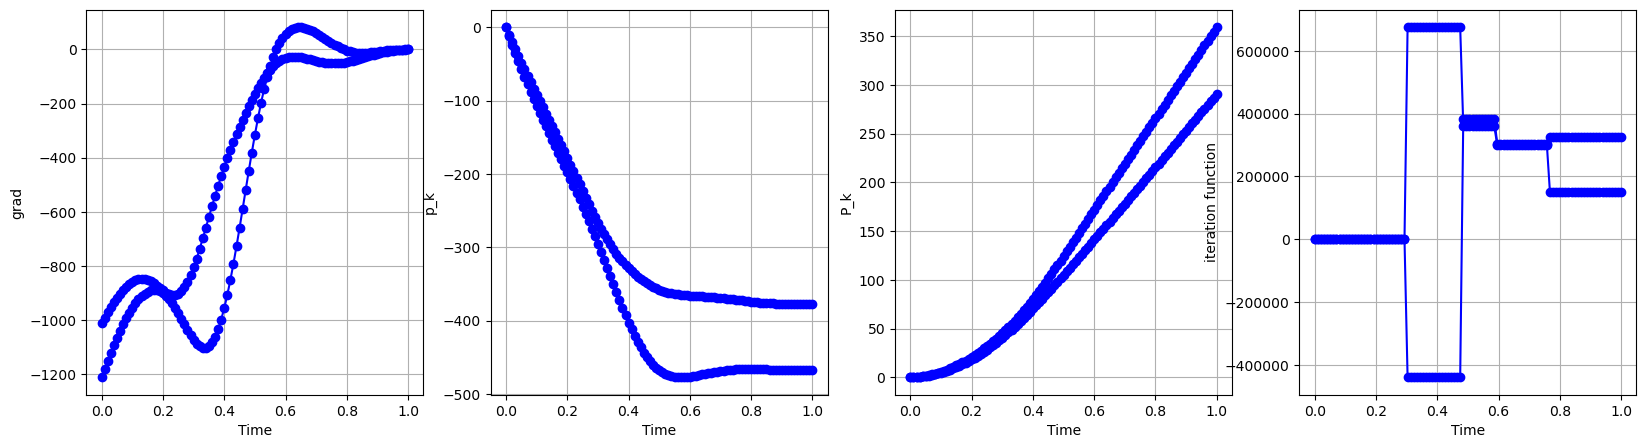

|p_max|/alpha:  600787908.7567197 , |P_max|/beta:  4560606.484749352
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62856966 -0.77775329] x_0 = 0.99 , type = 0
weights:  [8.80120179e-01 8.04713515e-01 1.55007158e-01 6.83747664e-05
 4.99935917e-02 5.14515446e-02 0.00000000e+00] slope:  [ 9.63250927 11.35770994] y_shift [21.31073692 25.77659475]
Objective:  46926260.70861807
5 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8801201789944334 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8047135145551119 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15500715833544063 	id: 139856754951808
	 3 sigma= [-0.62810608 -0.77812772] ,	x_0 = 0.5700000000000001 ,	type = 0 	weight: 6.837476638472641e-05 	id: 139856545757856
	 4 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04999359174134038 	id: 139856522447184
	 5 sigma= [-0.60896636 -0.79319605] ,	x_0

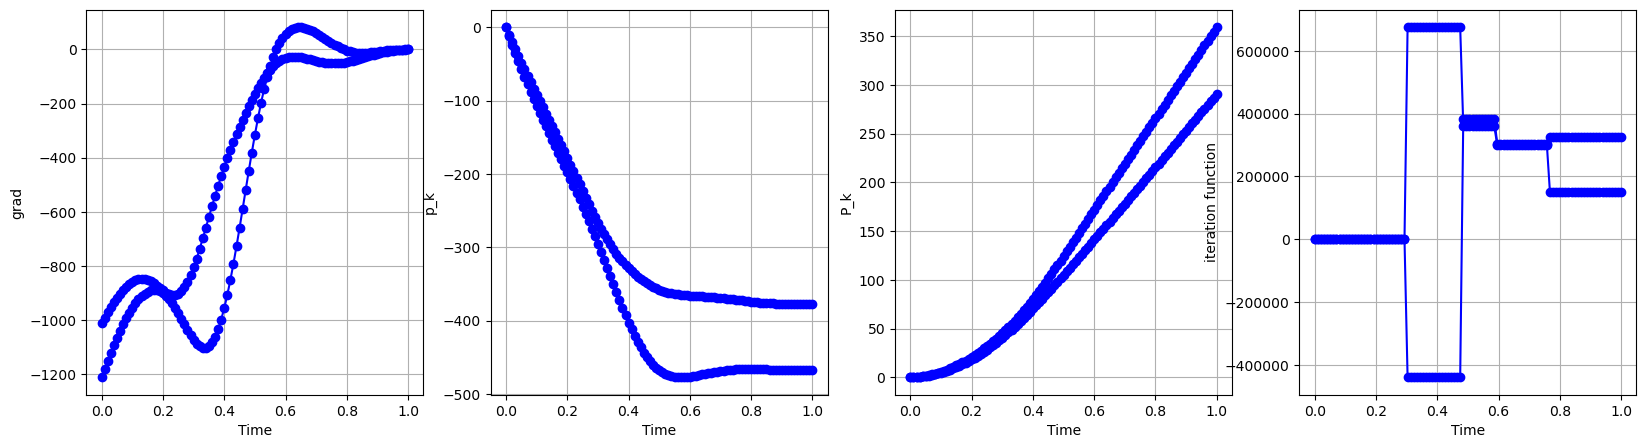

|p_max|/alpha:  600787908.7568077 , |P_max|/beta:  4560606.484750073
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62856966 -0.77775329] x_0 = 0.99 , type = 0
weights:  [0.88099487 0.80498985 0.15720677 0.         0.04995203 0.05198819
 0.        ] slope:  [12.58696126 15.71911577] y_shift [28.64940948 36.38913829]
Objective:  46917421.50242625
6 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8809948698499154 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8049898535957827 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15720676636457057 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04995203488871358 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.051988192362078633 	id: 139856525126896
slope:  [12.58696126 15.71911577] y_shift [28.64940948 36.38913829]
6 : Hesse conditi

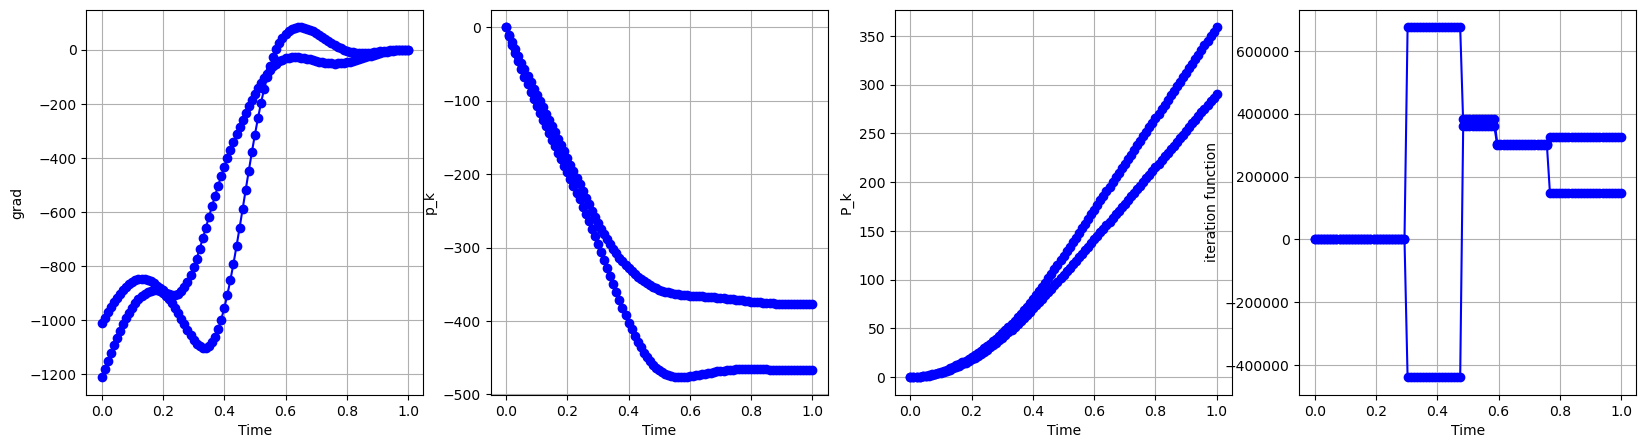

|p_max|/alpha:  600297667.6130136 , |P_max|/beta:  4556870.47030182
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62852187 -0.77779191] x_0 = 0.99 , type = 0
weights:  [0.88116211 0.80506162 0.1573059  0.04992753 0.05214126 0.        ] slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
Objective:  46917384.03007219
7 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8811621136181832 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8050616246569239 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15730589868923098 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04992752767176676 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.052141256572727036 	id: 139856525126896
slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
7 : Hesse condition: 148684843

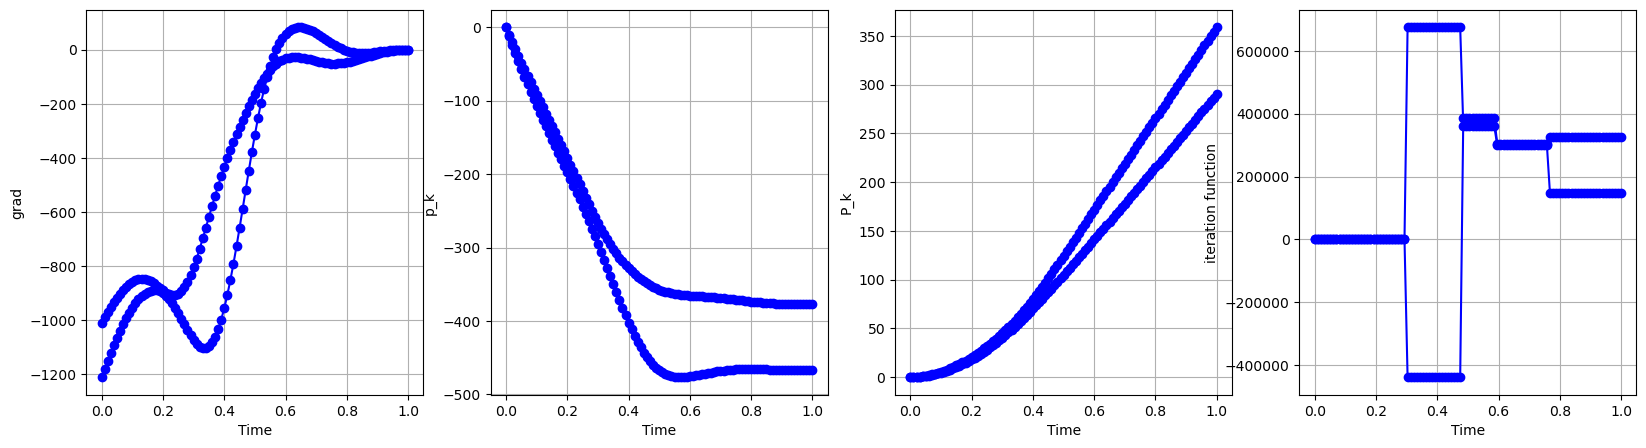

|p_max|/alpha:  600229453.0543654 , |P_max|/beta:  4556366.433494337
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.6284918  -0.77781621] x_0 = 0.99 , type = 0
weights:  [0.88116211 0.80506162 0.1573059  0.04992753 0.05214126 0.        ] slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
Objective:  46917384.03007219
8 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8811621136181857 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8050616246569242 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15730589868925268 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049927527671766 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05214125657272586 	id: 139856525126896
slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
8 : Hesse condition: 14868484382

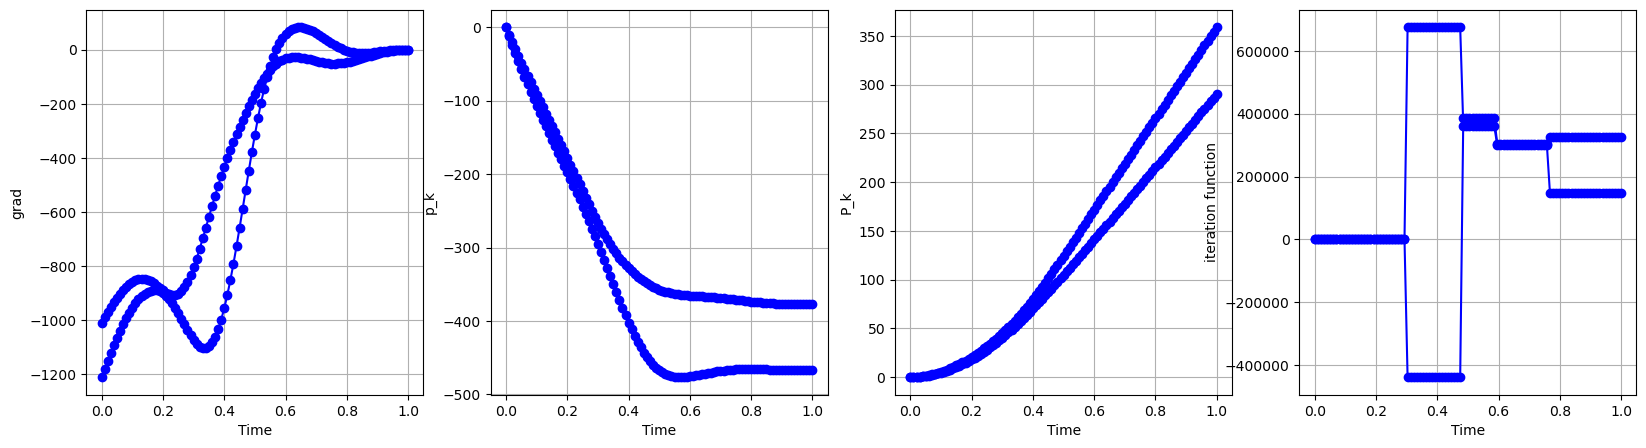

|p_max|/alpha:  600229453.0543634 , |P_max|/beta:  4556366.43349432
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.6284918  -0.77781621] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725084
9 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724729114 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8046533648649886 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101253541 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515255304 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.051481260974531255 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
9 : Hesse condition: 14868484

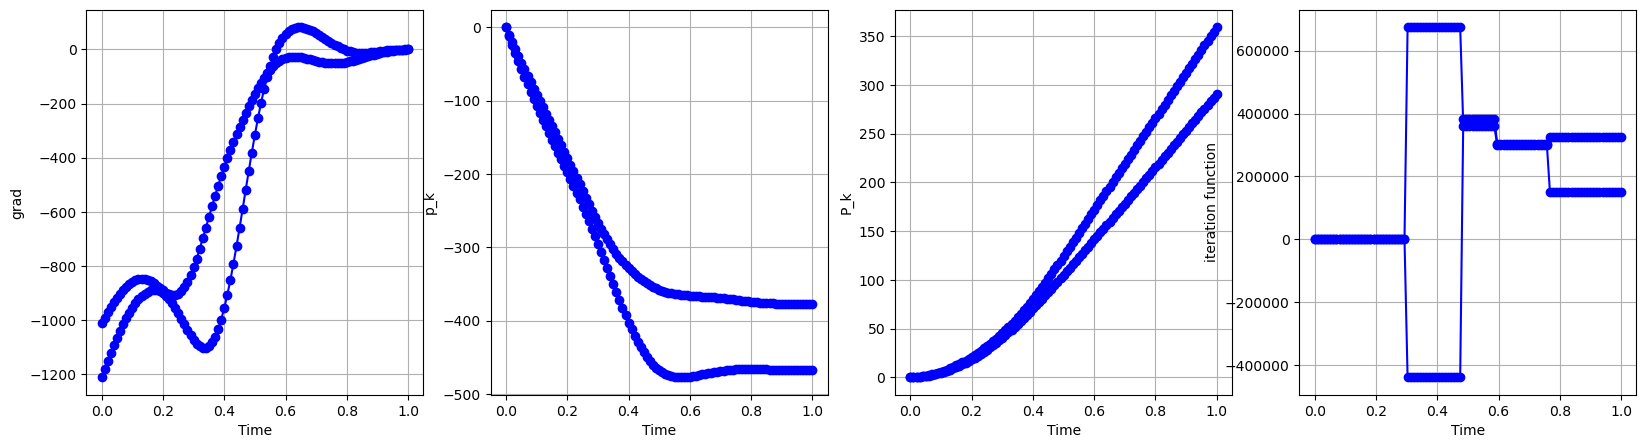

|p_max|/alpha:  600855093.8439487 , |P_max|/beta:  4561094.432948925
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
10 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
10 : Hesse condition: 1486848

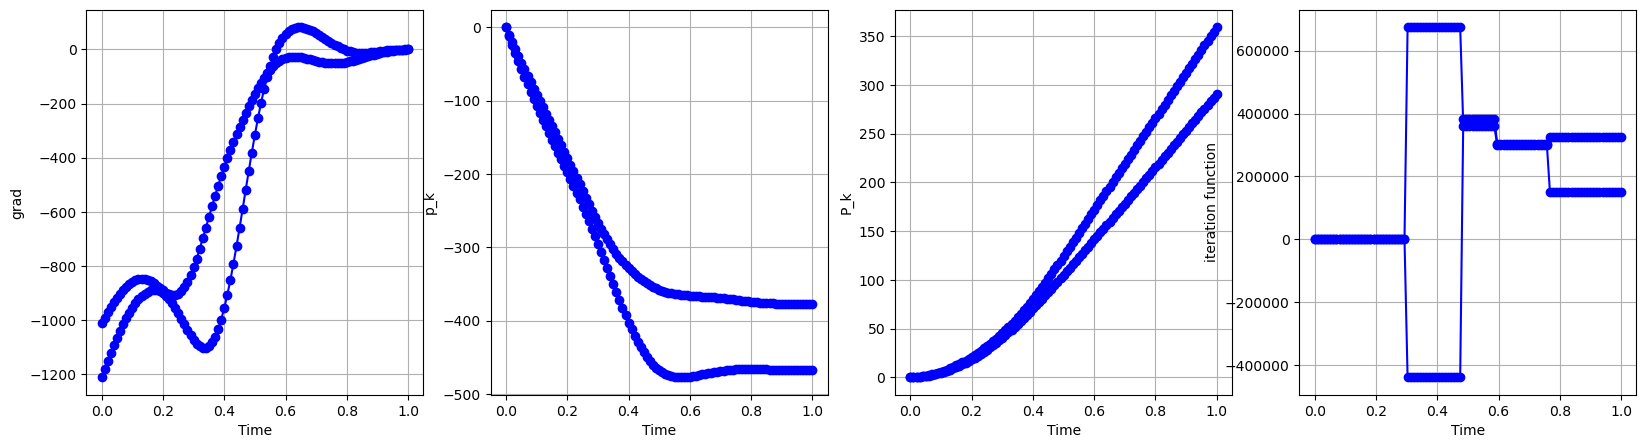

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
11 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
11 : Hesse condition: 14868484

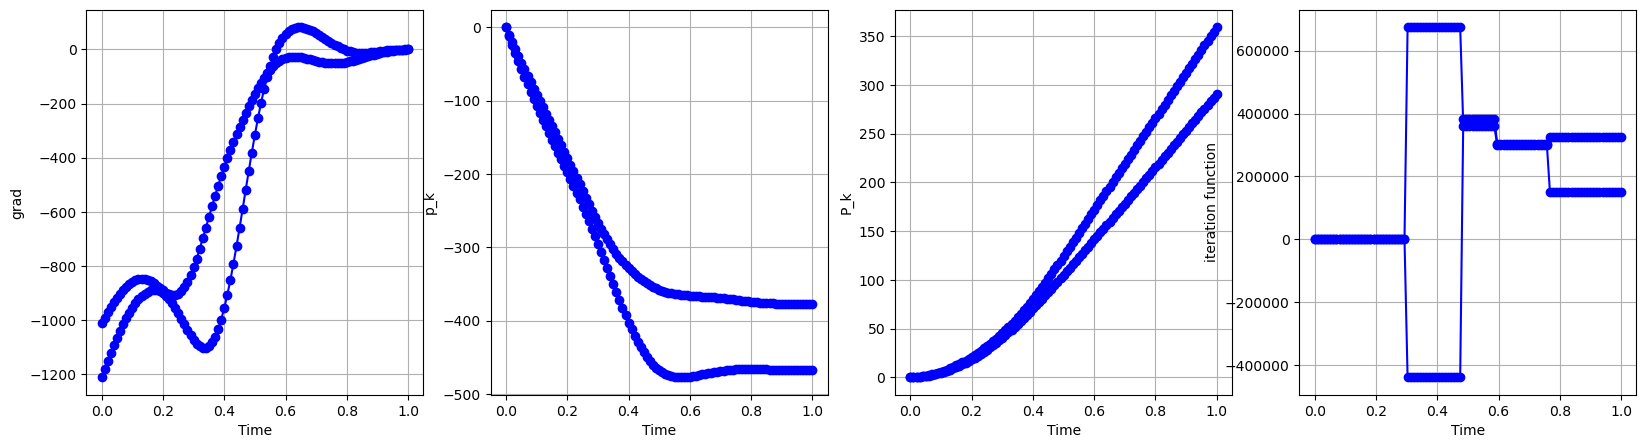

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.88116211 0.80506162 0.1573059  0.04992753 0.05214126 0.        ] slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
Objective:  46917384.030072175
12 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.881162113618179 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8050616246569243 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15730589868918057 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04992752767176862 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05214125657273147 	id: 139856525126896
slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
12 : Hesse condition: 14868484

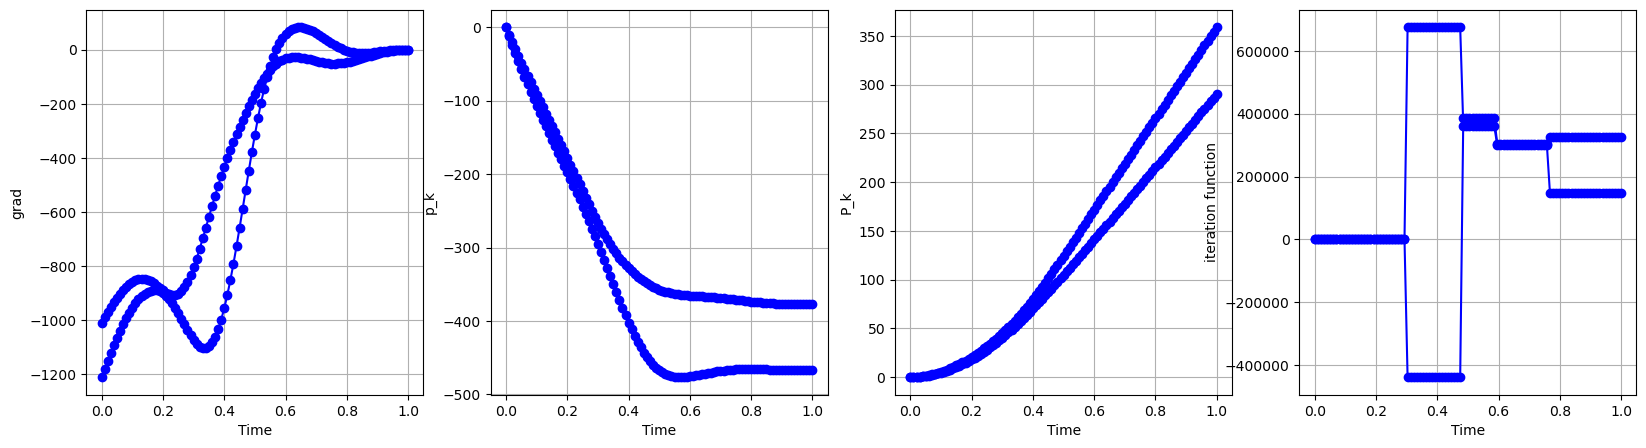

|p_max|/alpha:  600229453.0543689 , |P_max|/beta:  4556366.433494364
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.6284918  -0.77781621] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725084
13 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724729114 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8046533648649886 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101253541 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515255304 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.051481260974531255 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
13 : Hesse condition: 14868

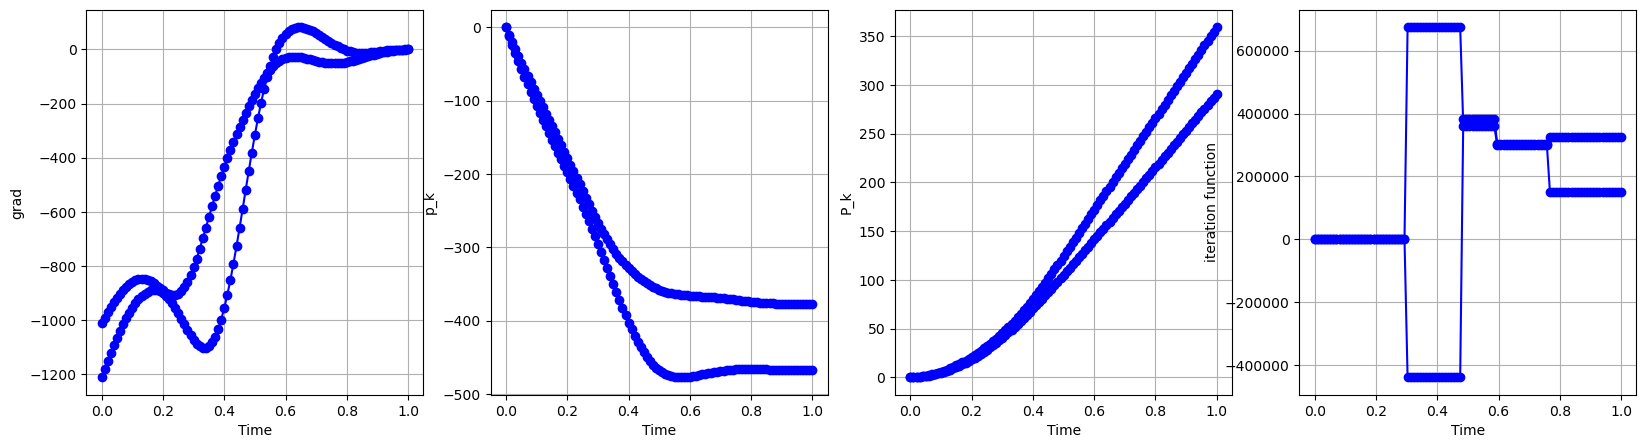

|p_max|/alpha:  600855093.8439487 , |P_max|/beta:  4561094.432948925
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
14 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
14 : Hesse condition: 1486848

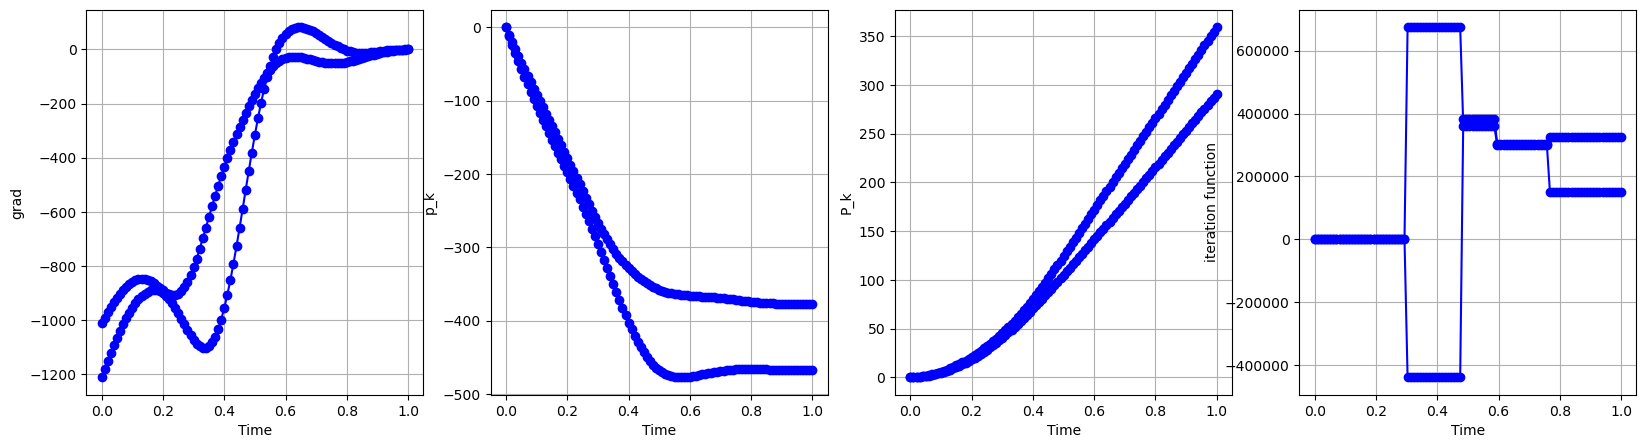

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
15 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
15 : Hesse condition: 14868484

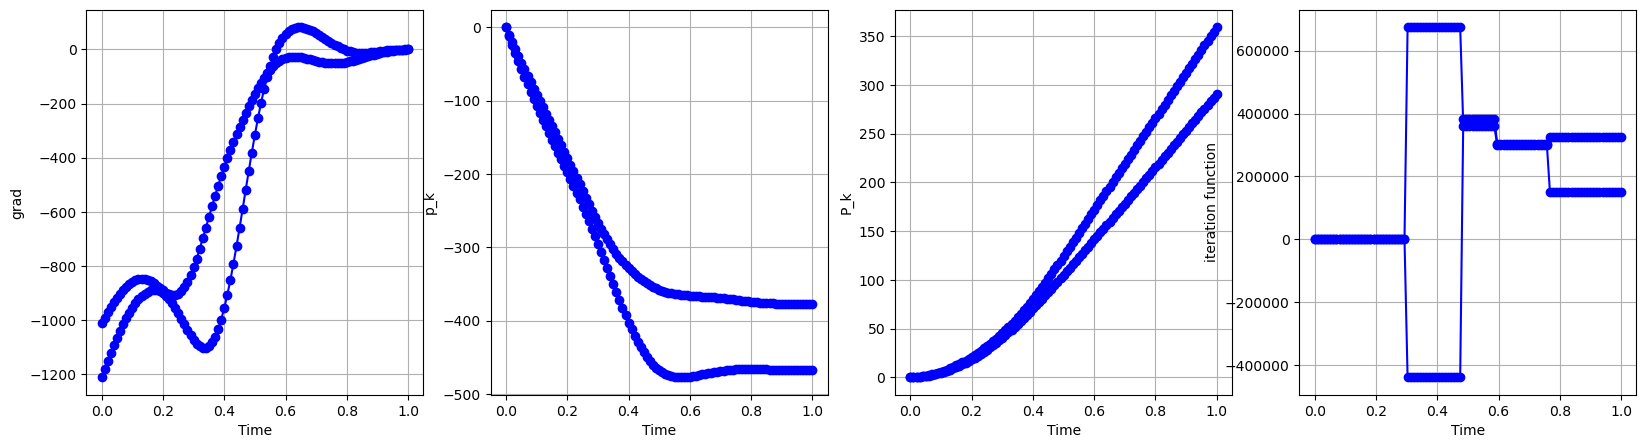

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [8.81921880e-01 8.05365420e-01 1.57845123e-01 2.18047055e-05
 1.02716810e-01 6.86874543e-09] slope:  [14.76622208 19.13059194] y_shift [34.38828018 45.35863838]
Objective:  46909524.551996365
16 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.881921879670374 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.805365420450592 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15784512281378393 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 2.1804705488085868e-05 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.10271680995064159 	id: 139856525126896
slope:  [14.76622208 19.13059194] y_shift [34.38828018 45.35863838]
16 

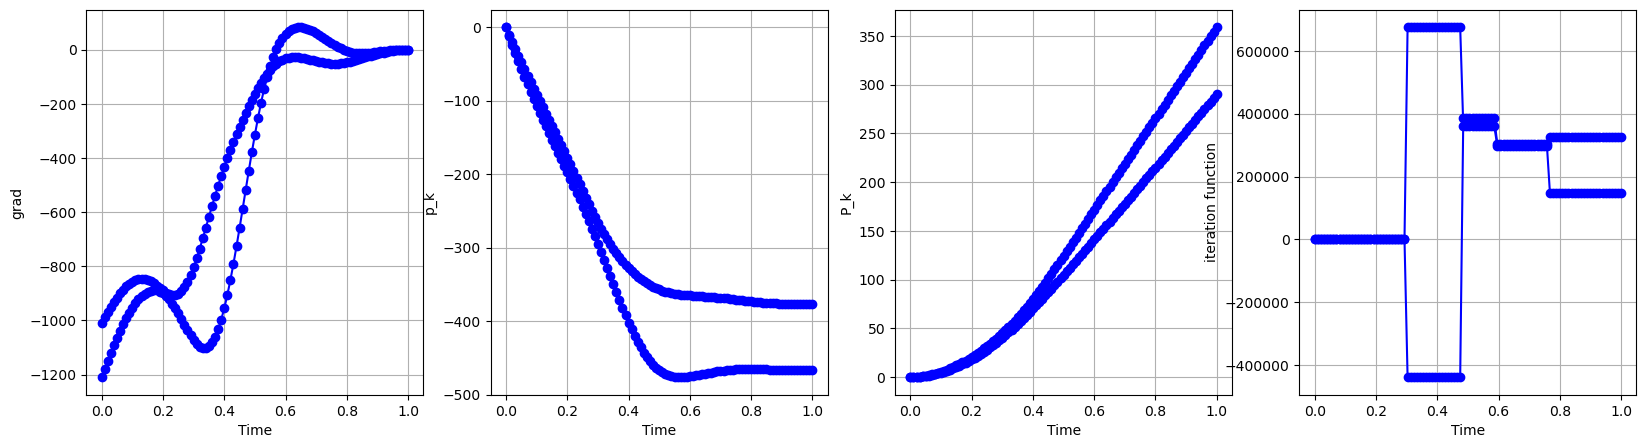

|p_max|/alpha:  599914923.1965549 , |P_max|/beta:  4553930.416564963
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62837844 -0.77790779] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.417250834
17 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724729241 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8046533648649877 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101268044 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04994425451524906 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097452404 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
17 : Hesse condition: 148684

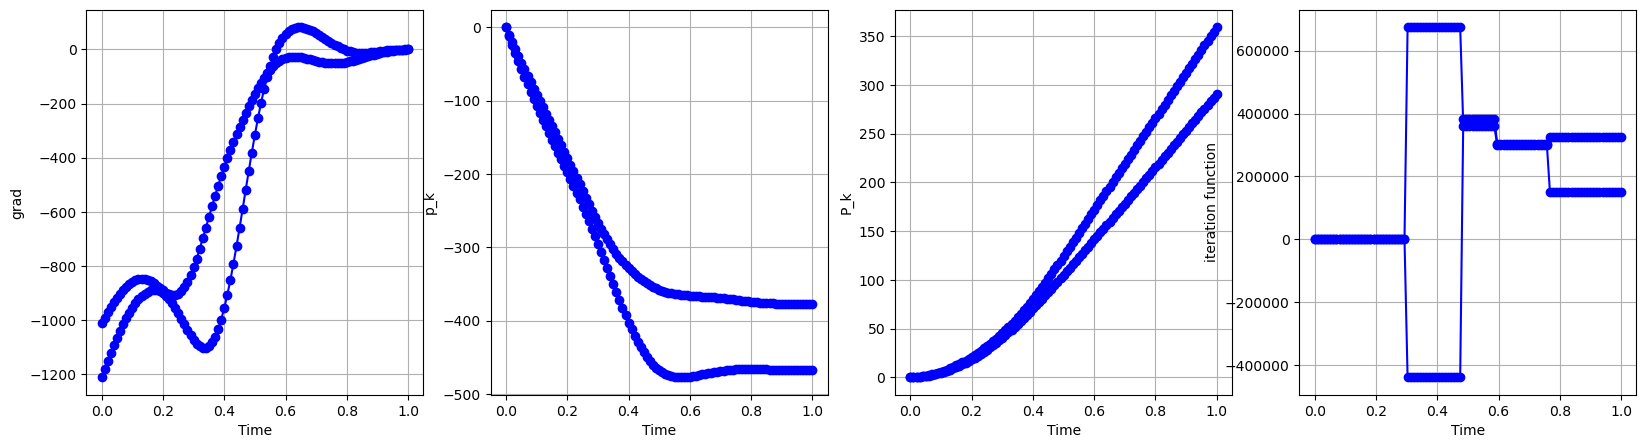

|p_max|/alpha:  600855093.8439434 , |P_max|/beta:  4561094.432948875
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.88116211 0.80506162 0.1573059  0.04992753 0.05214126 0.        ] slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
Objective:  46917384.030072175
18 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.881162113618179 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8050616246569243 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15730589868918057 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04992752767176862 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05214125657273147 	id: 139856525126896
slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
18 : Hesse condition: 1486848

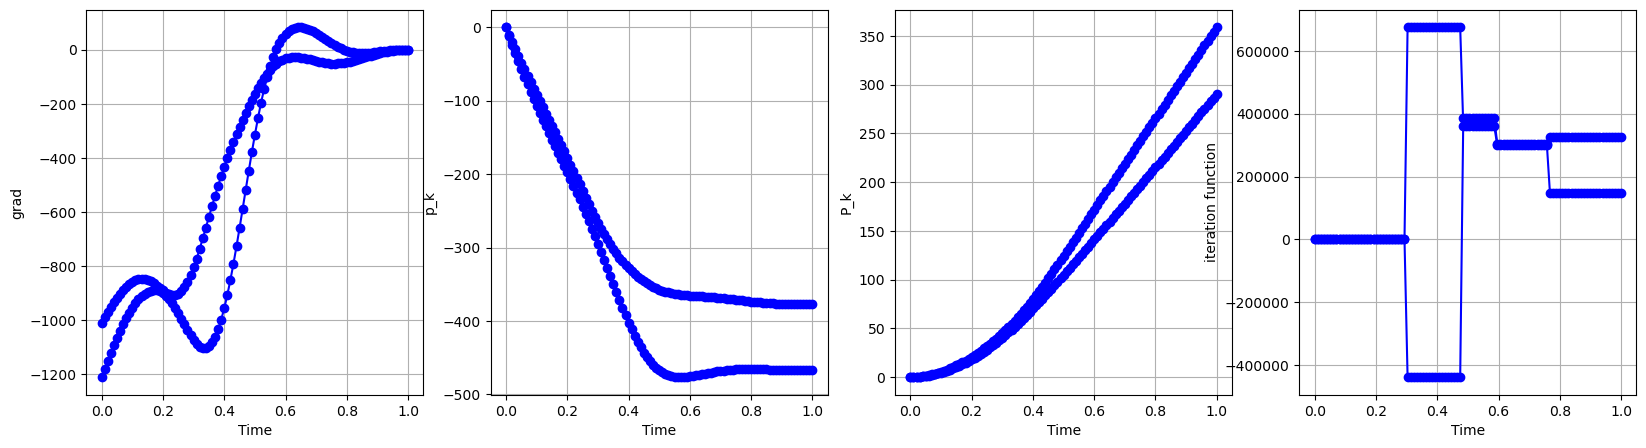

|p_max|/alpha:  600229453.0543689 , |P_max|/beta:  4556366.433494364
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.6284918  -0.77781621] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725084
19 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724729114 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8046533648649886 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101253541 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515255304 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.051481260974531255 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
19 : Hesse condition: 14868

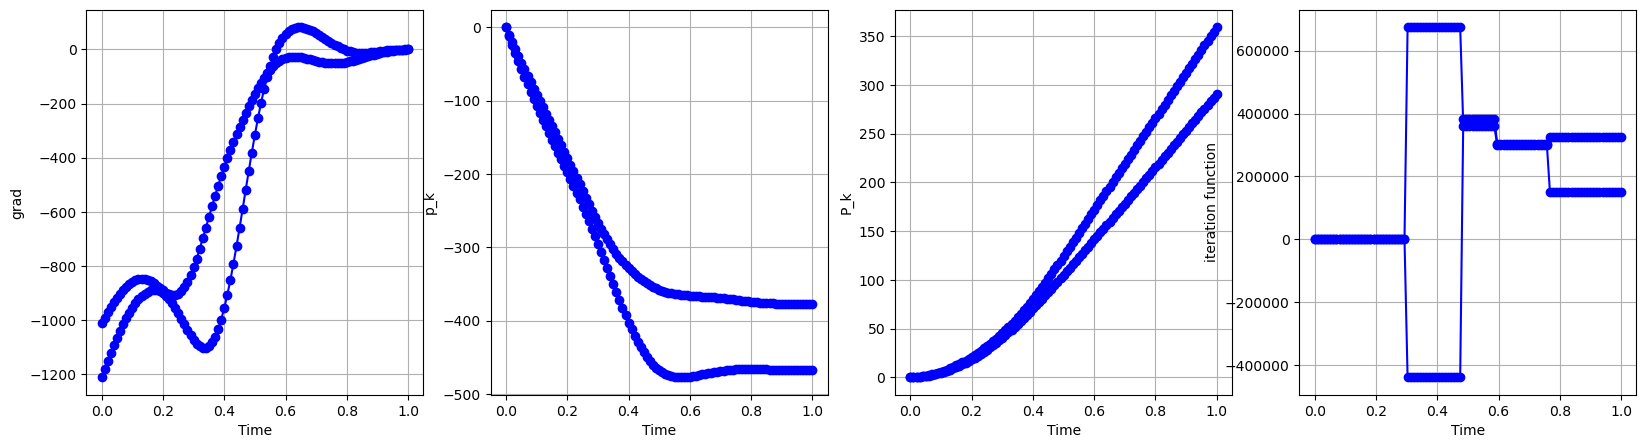

|p_max|/alpha:  600855093.8439487 , |P_max|/beta:  4561094.432948925
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
20 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
20 : Hesse condition: 1486848

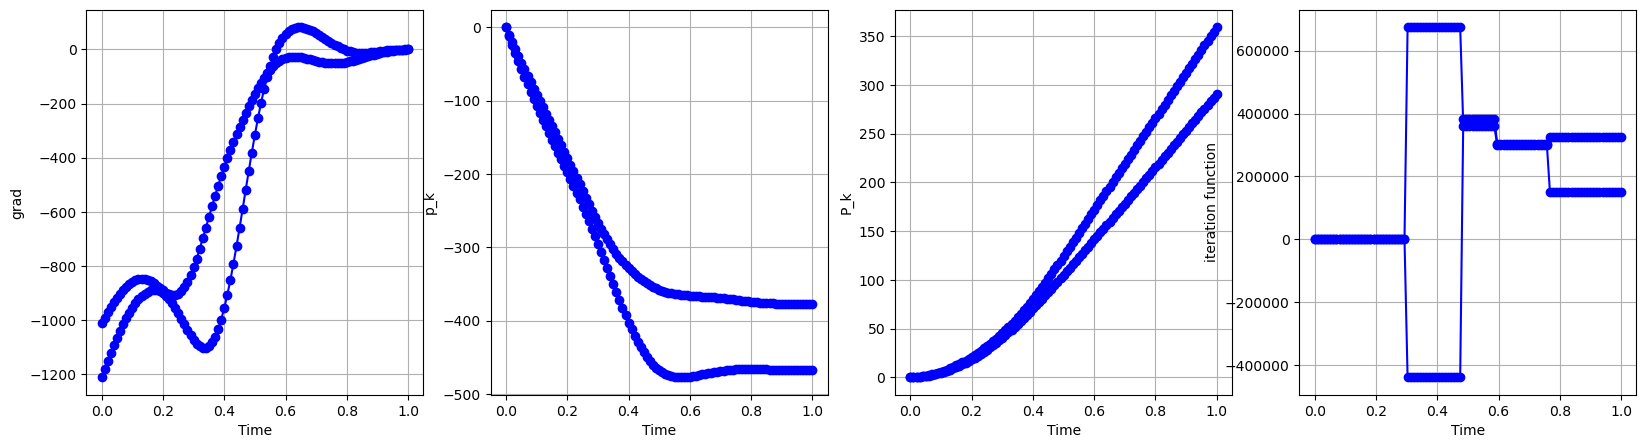

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [8.81881596e-01 8.05349410e-01 1.57814427e-01 6.55637270e-05
 1.02696994e-01 6.03734288e-08] slope:  [16.85839251 22.43027026] y_shift [39.93940411 54.12717034]
Objective:  46902716.405862115
21 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8818815956279863 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8053494100078996 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15781442727606584 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 6.556372702396979e-05 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.10269699416050343 	id: 139856525126896
slope:  [16.85839251 22.43027026] y_shift [39.93940411 54.12717034]
21

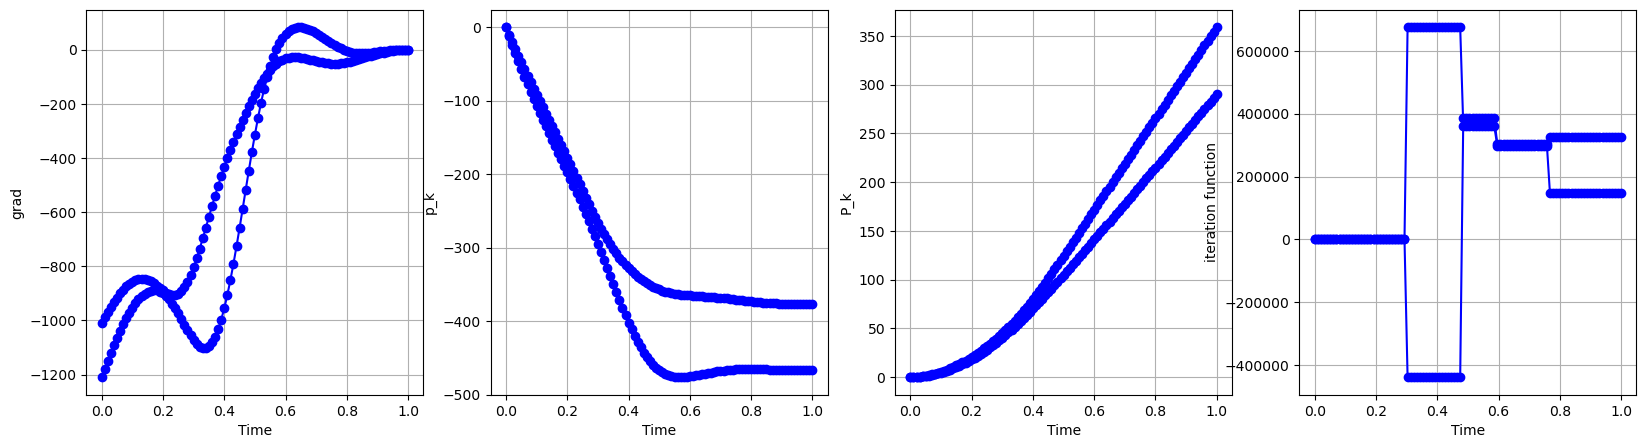

|p_max|/alpha:  599850590.5723476 , |P_max|/beta:  4553429.590085294
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62838577 -0.77790188] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.417250834
22 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724729234 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8046533648649877 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101267142 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515248726 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.051481260974525135 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
22 : Hesse condition: 1486

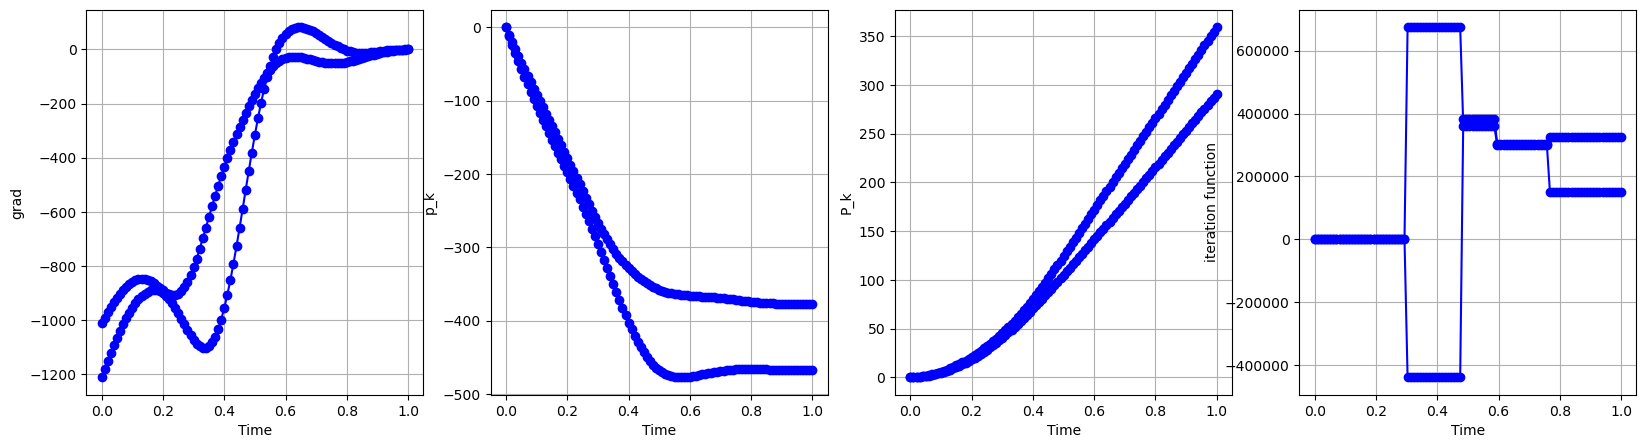

|p_max|/alpha:  600855093.8439436 , |P_max|/beta:  4561094.432948877
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.88116211 0.80506162 0.1573059  0.04992753 0.05214126 0.        ] slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
Objective:  46917384.030072175
23 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.881162113618179 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8050616246569243 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15730589868918057 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04992752767176862 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05214125657273147 	id: 139856525126896
slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
23 : Hesse condition: 1486848

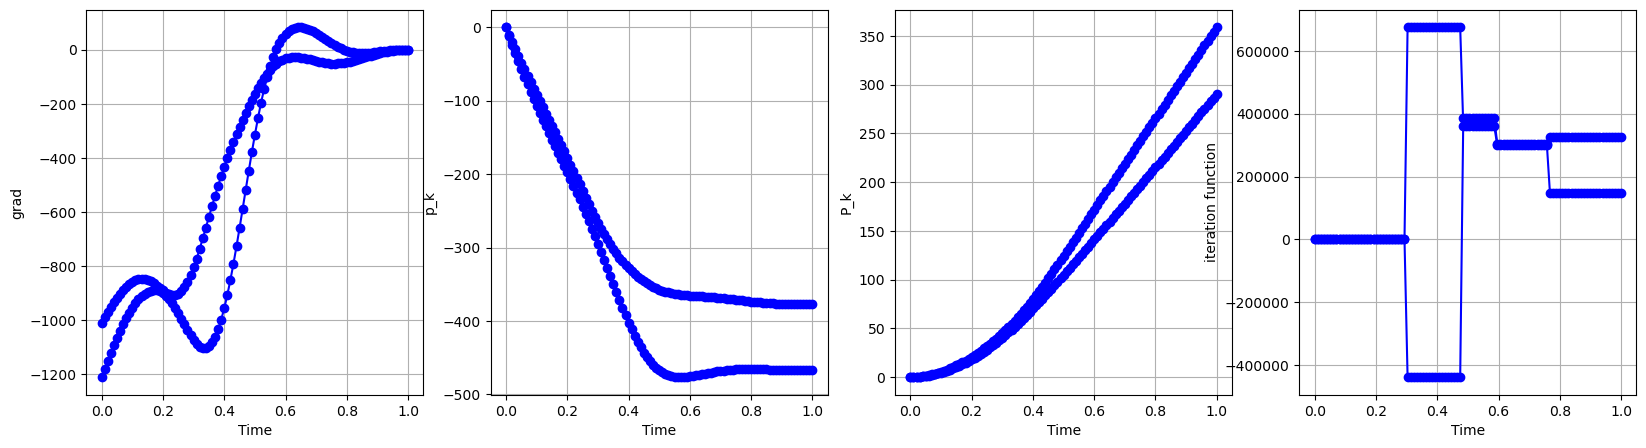

|p_max|/alpha:  600229453.0543689 , |P_max|/beta:  4556366.433494364
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.6284918  -0.77781621] x_0 = 0.99 , type = 0
weights:  [0.88116211 0.80506162 0.1573059  0.04992753 0.05214126 0.        ] slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
Objective:  46917384.03007219
24 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8811621136181857 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8050616246569242 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15730589868925268 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049927527671766 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05214125657272586 	id: 139856525126896
slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
24 : Hesse condition: 148684843

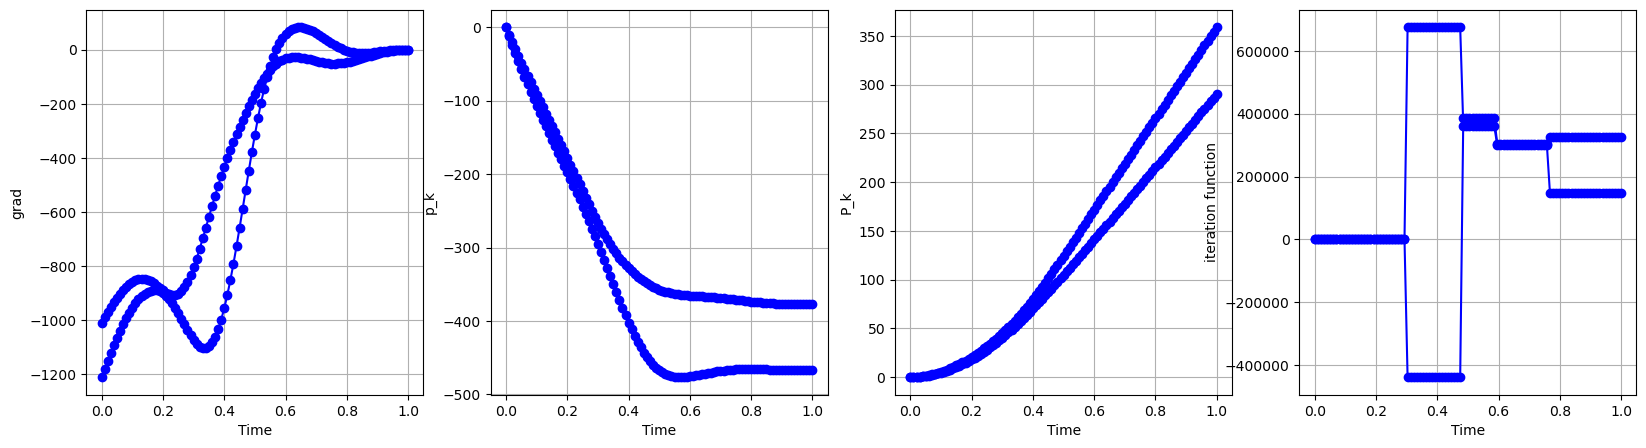

|p_max|/alpha:  600229453.0543634 , |P_max|/beta:  4556366.43349432
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.6284918  -0.77781621] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725084
25 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724729114 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8046533648649886 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101253541 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515255304 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.051481260974531255 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
25 : Hesse condition: 148684

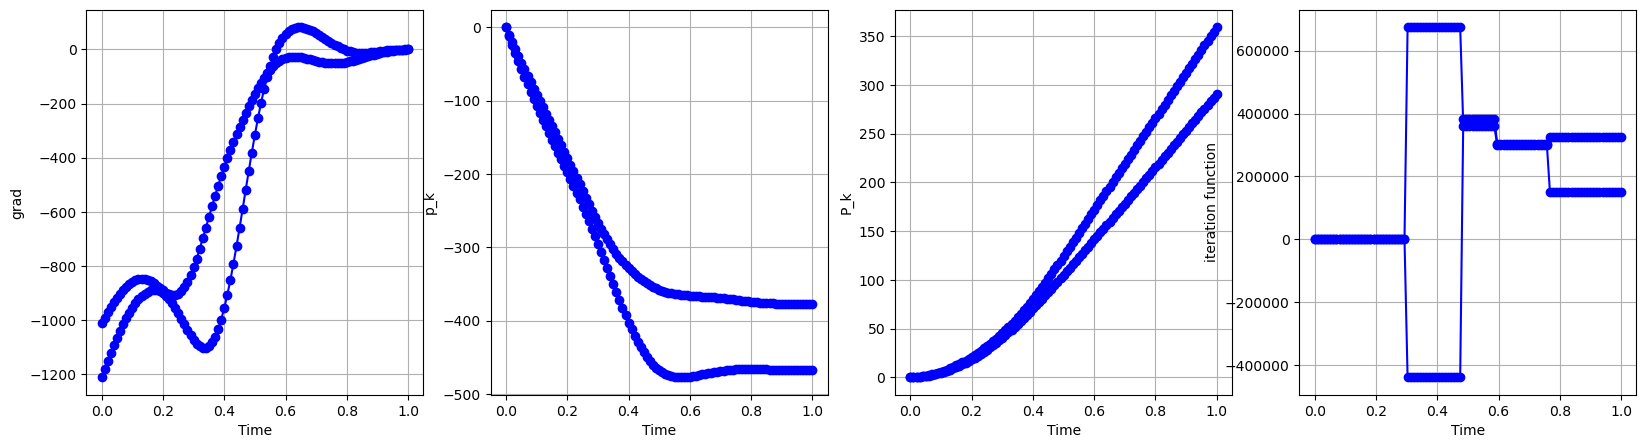

|p_max|/alpha:  600855093.8439487 , |P_max|/beta:  4561094.432948925
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
26 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
26 : Hesse condition: 1486848

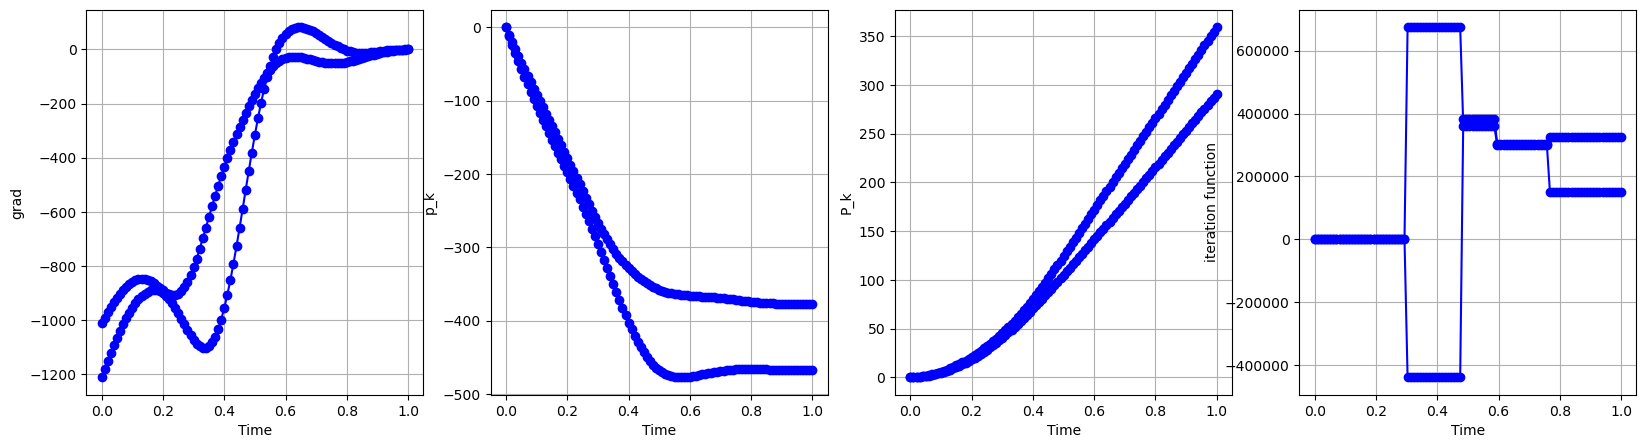

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
27 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
27 : Hesse condition: 14868484

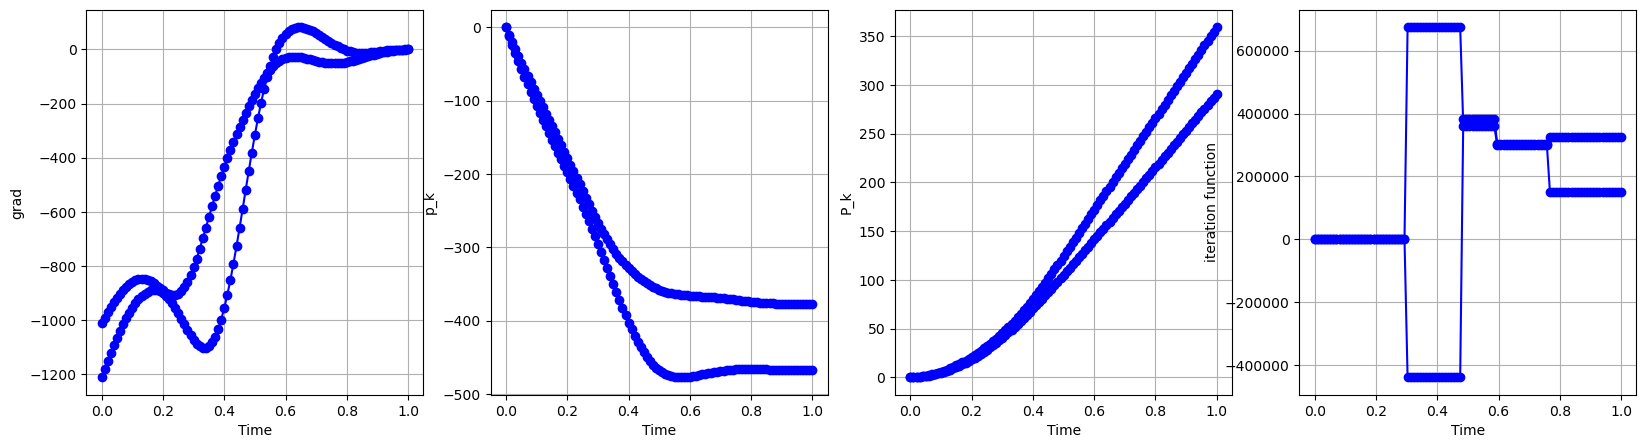

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.88116211 0.80506162 0.1573059  0.04992753 0.05214126 0.        ] slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
Objective:  46917384.030072175
28 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.881162113618179 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8050616246569243 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15730589868918057 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04992752767176862 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05214125657273147 	id: 139856525126896
slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
28 : Hesse condition: 14868484

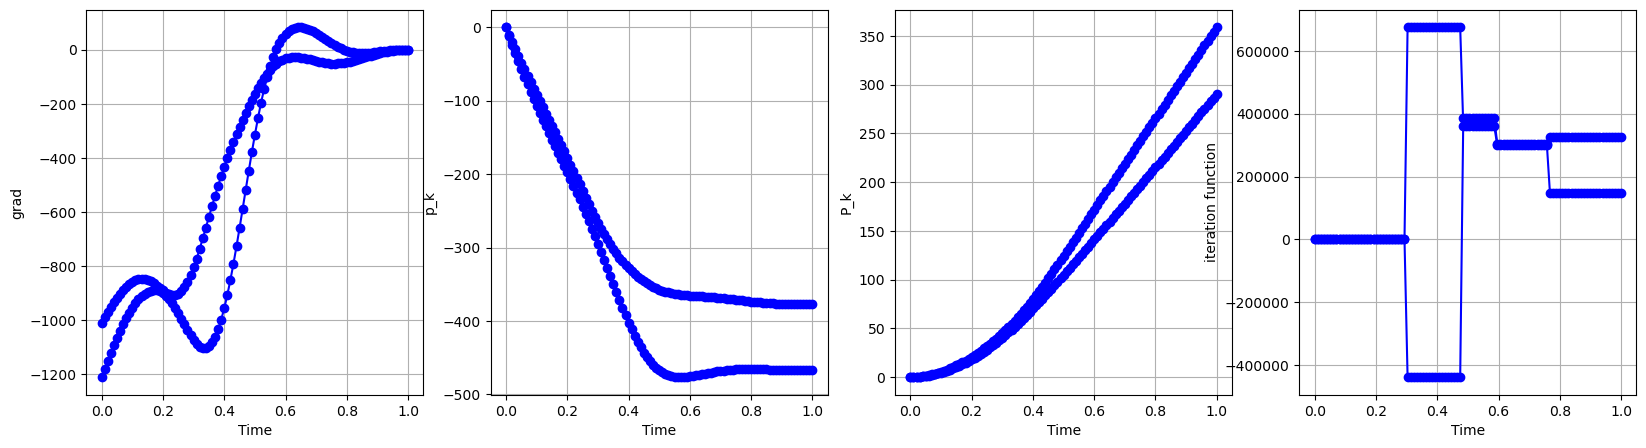

|p_max|/alpha:  600229453.0543689 , |P_max|/beta:  4556366.433494364
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.6284918  -0.77781621] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725084
29 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724729114 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8046533648649886 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101253541 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515255304 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.051481260974531255 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
29 : Hesse condition: 14868

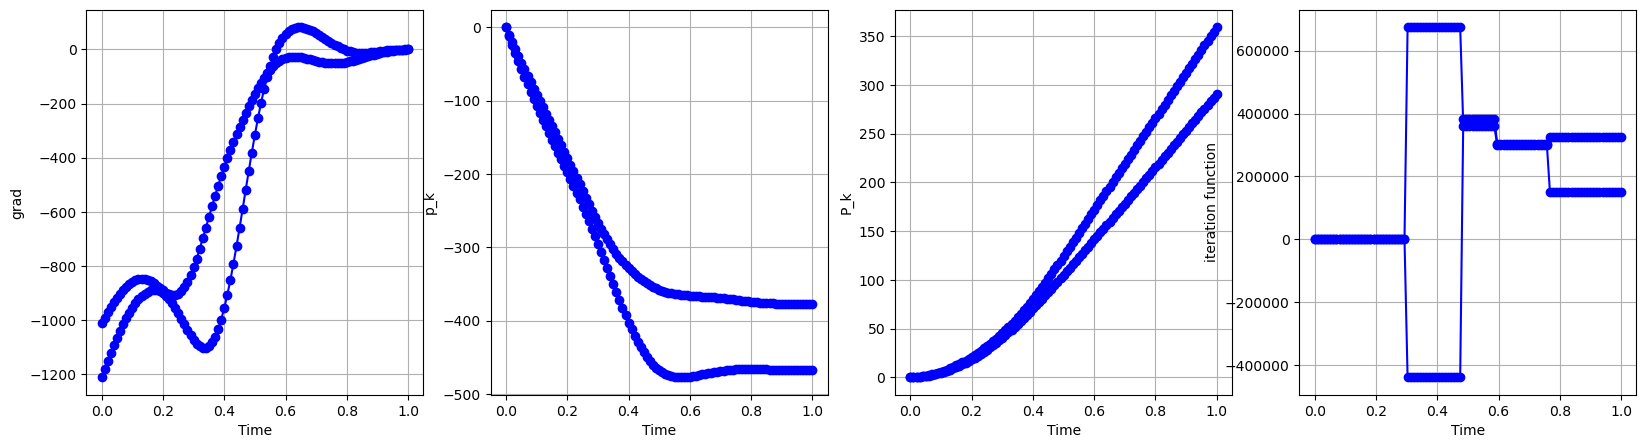

|p_max|/alpha:  600855093.8439487 , |P_max|/beta:  4561094.432948925
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
30 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
30 : Hesse condition: 1486848

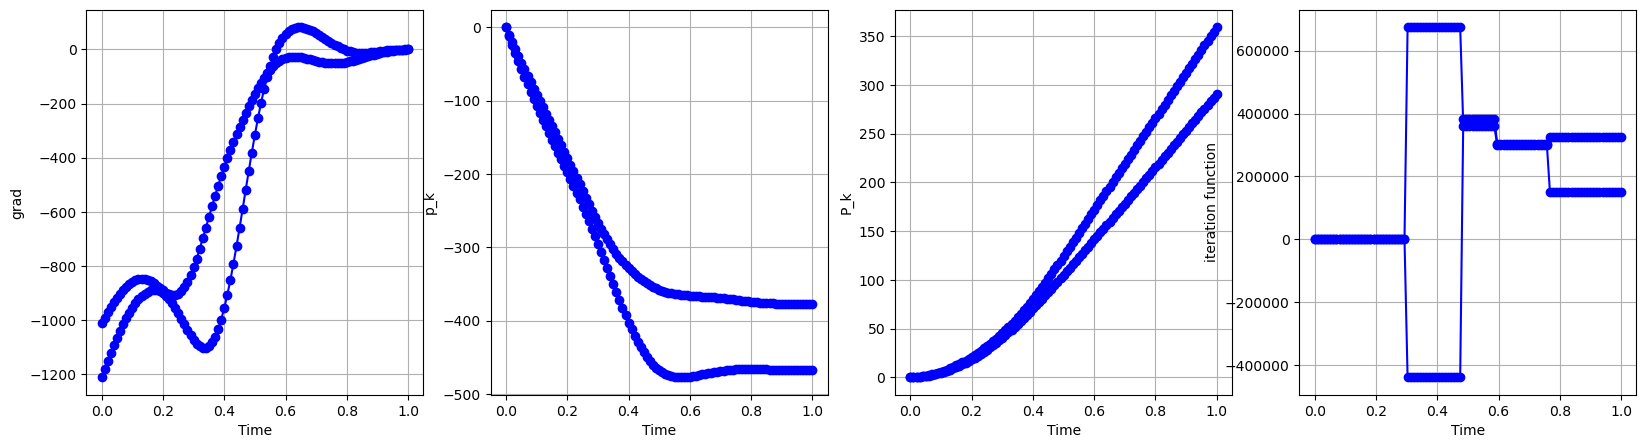

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
31 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
31 : Hesse condition: 14868484

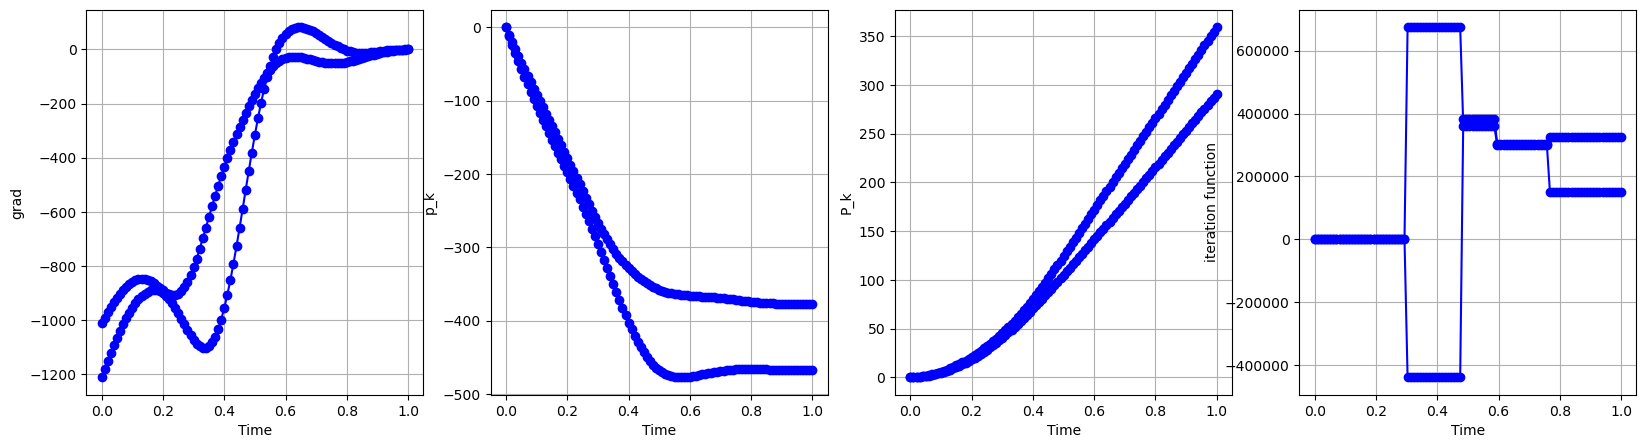

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.88116211 0.80506162 0.1573059  0.04992753 0.05214126 0.        ] slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
Objective:  46917384.030072175
32 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.881162113618179 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8050616246569243 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15730589868918057 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.04992752767176862 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05214125657273147 	id: 139856525126896
slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
32 : Hesse condition: 14868484

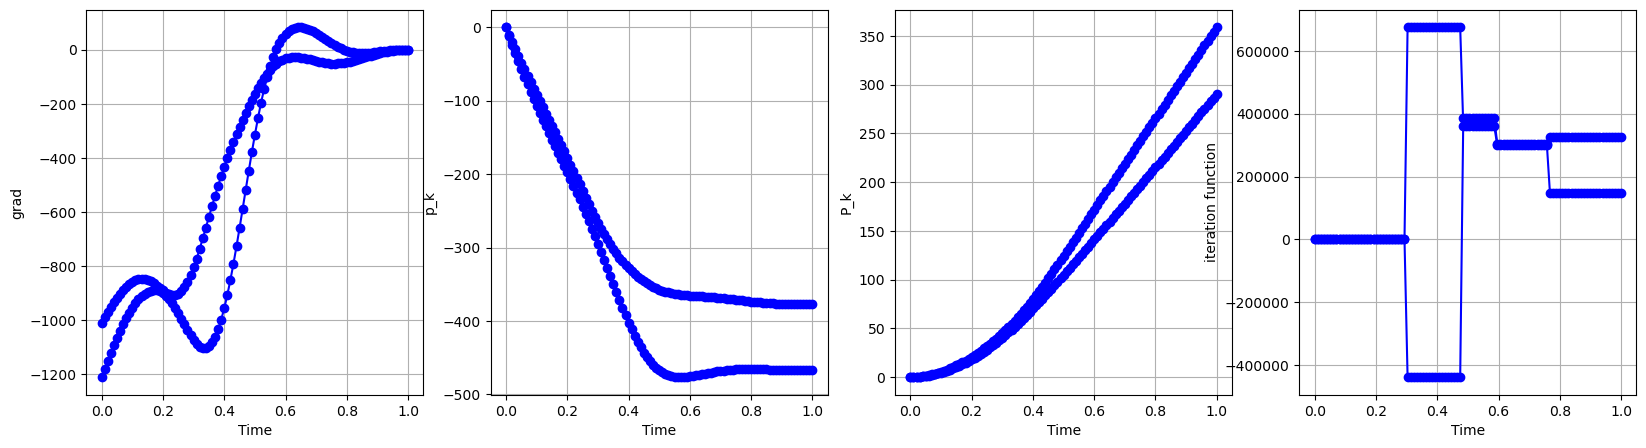

|p_max|/alpha:  600229453.0543689 , |P_max|/beta:  4556366.433494364
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.6284918  -0.77781621] x_0 = 0.99 , type = 0
weights:  [0.88116211 0.80506162 0.1573059  0.04992753 0.05214126 0.        ] slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
Objective:  46917384.03007219
33 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8811621136181857 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8050616246569242 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15730589868925268 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049927527671766 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05214125657272586 	id: 139856525126896
slope:  [12.5929233  15.73652979] y_shift [28.66206129 36.41648665]
33 : Hesse condition: 148684843

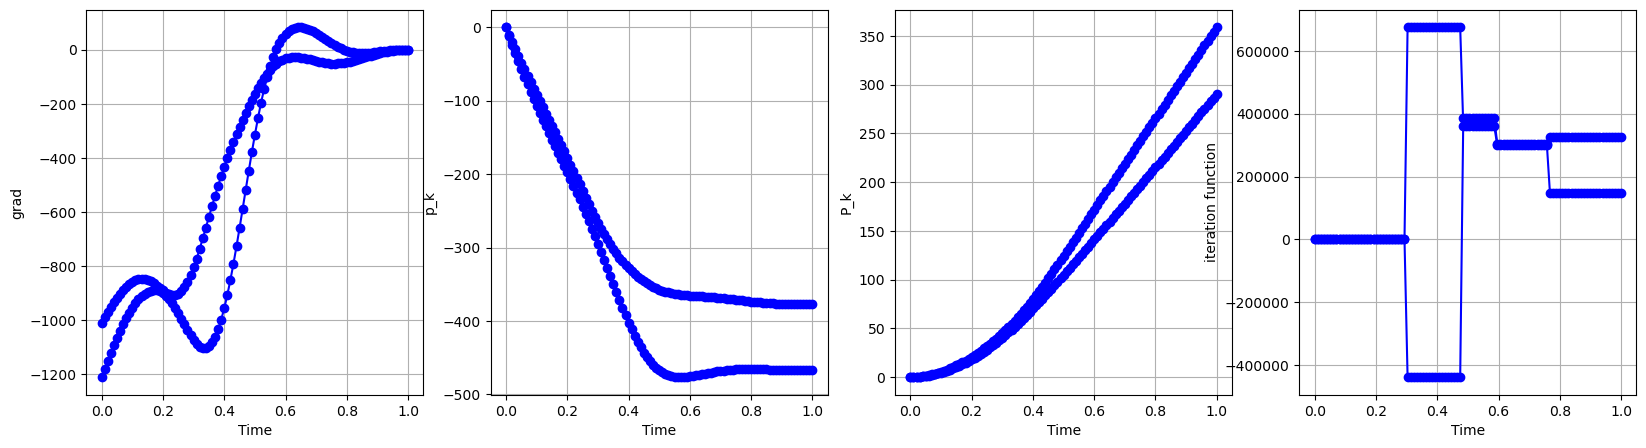

|p_max|/alpha:  600229453.0543634 , |P_max|/beta:  4556366.43349432
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.6284918  -0.77781621] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725084
34 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724729114 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.8046533648649886 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101253541 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515255304 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.051481260974531255 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
34 : Hesse condition: 148684

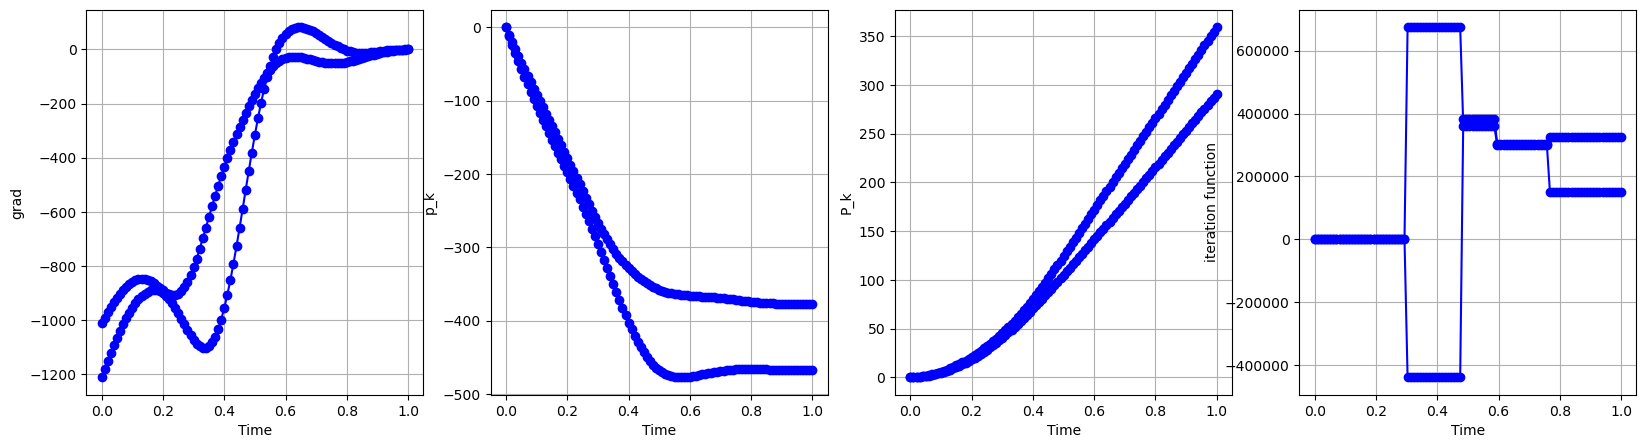

|p_max|/alpha:  600855093.8439487 , |P_max|/beta:  4561094.432948925
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
35 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
35 : Hesse condition: 1486848

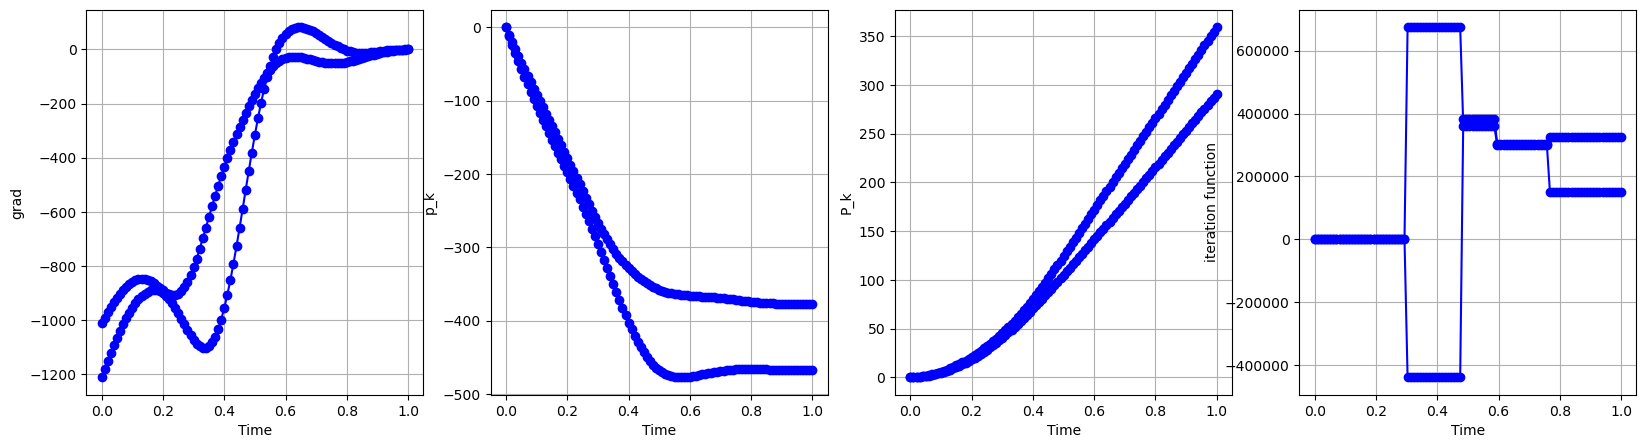

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
36 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
36 : Hesse condition: 14868484

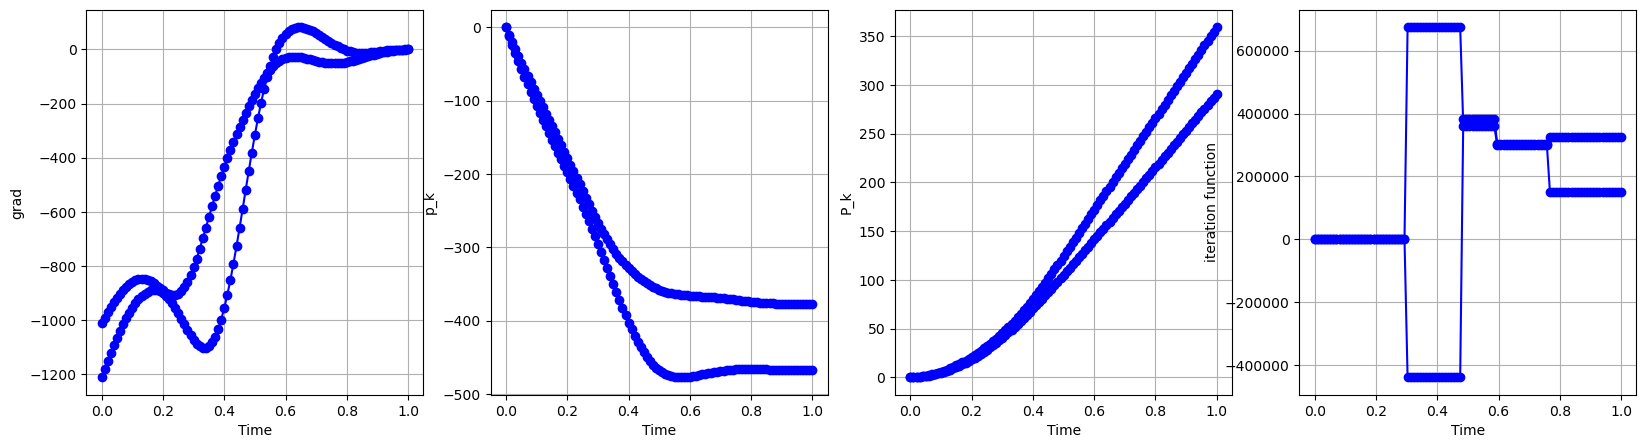

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
37 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
37 : Hesse condition: 14868484

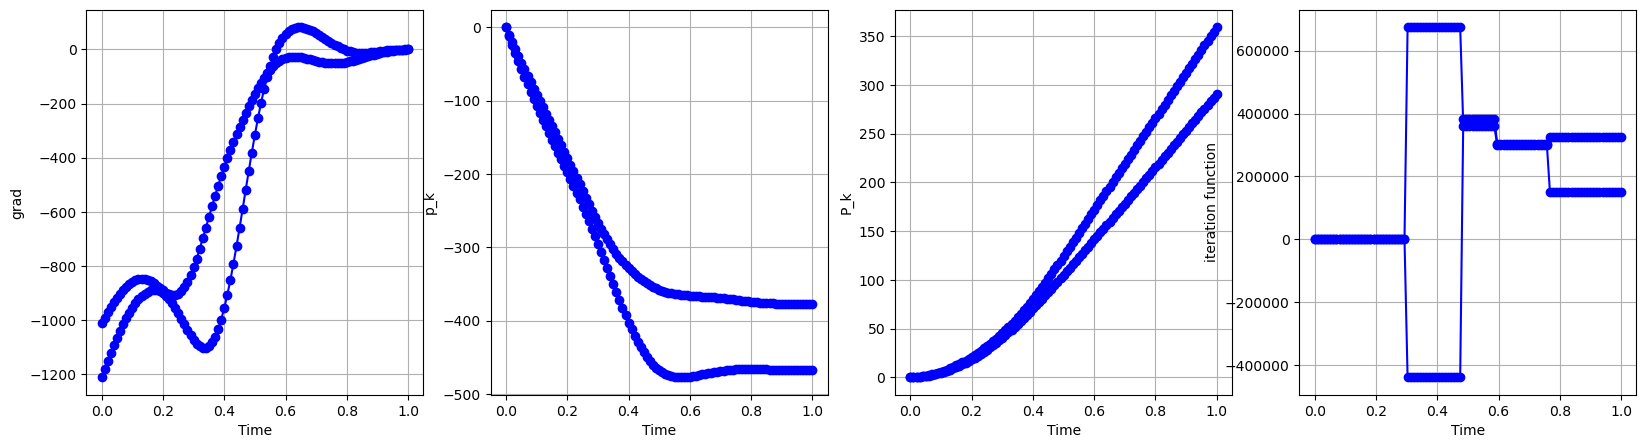

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
38 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
38 : Hesse condition: 14868484

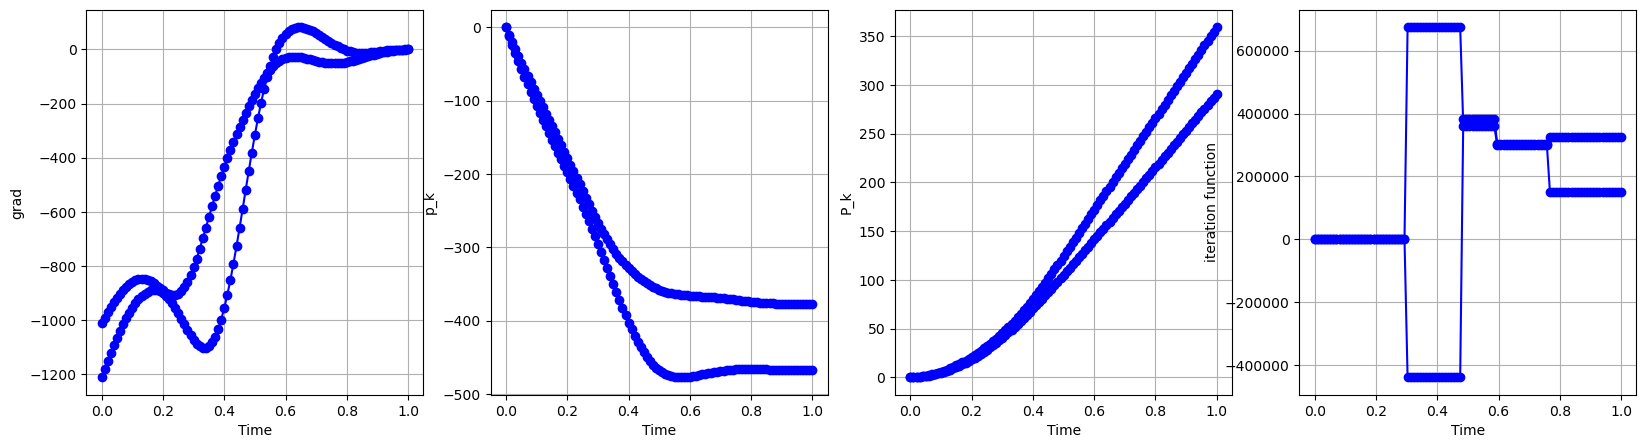

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0
weights:  [0.87997367 0.80465336 0.15486211 0.04994425 0.05148126 0.        ] slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
Objective:  46926264.41725087
39 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 0.8799736724728974 	id: 139858099583936
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 0.804653364864988 	id: 139856547321984
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 0.15486211101240605 	id: 139856754951808
	 3 sigma= [-0.60983027 -0.79253204] ,	x_0 = 0.59 ,	type = 0 	weight: 0.049944254515259696 	id: 139856522447184
	 4 sigma= [-0.60896636 -0.79319605] ,	x_0 = 0.59 ,	type = 0 	weight: 0.05148126097453636 	id: 139856525126896
slope:  [ 9.61747908 11.34474433] y_shift [21.30316243 25.74853491]
39 : Hesse condition: 14868484

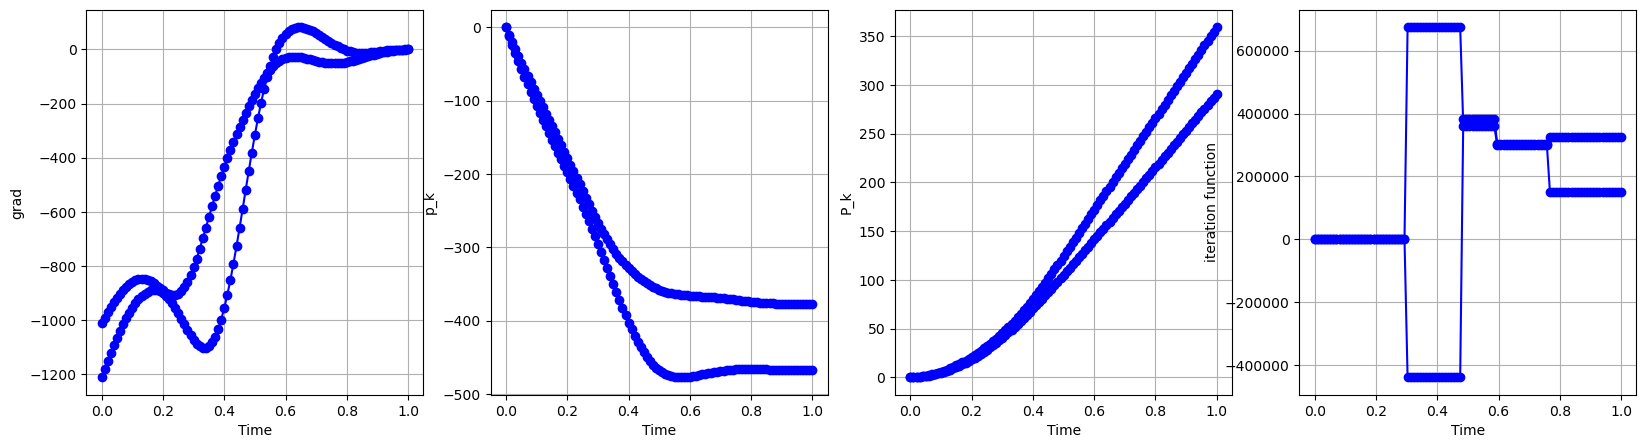

|p_max|/alpha:  600855093.843954 , |P_max|/beta:  4561094.432948971
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.62859301 -0.77773442] x_0 = 0.99 , type = 0


In [3]:
def algorithm(active_set: List[ExtremalPoint], weights: np.ndarray, slope: np.ndarray, y_shift: np.ndarray, params):
    hesse = HesseMatrix(active_set, params)
    constraintViolation = np.empty(params.maxIterations)
    constraintViolation[:] = np.nan
    print('Objective upper bound: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
    weights, slope, y_shift = computeOSQPStep(weights, slope, y_shift, active_set, hesse, params)
    print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
    print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
    for k in range(params.maxIterations):
        printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
        u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
        discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse.standard_adjoints, params)
        p_k = integrateVectorFunction(discreteDf, params)
        P_k = -integrateVectorFunction(p_k, params)
        
        fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
        plot_array(discreteDf, params.T, label='grad', ax=ax1)
        plot_array(p_k, params.T, label='p_k', ax=ax2)
        plot_array(P_k, params.T, label='P_k', ax=ax3)
        plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function', ax=ax4)
        mpl.pyplot.show()
        
        idx_S = getIdxMax(p_k, active_set, type=0)
        idx_K = getIdxMax(P_k, active_set, type=1)
        norm_p_max = np.linalg.norm(p_k[idx_S])
        norm_P_max = np.linalg.norm(P_k[idx_K])
        
        print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
        constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
        if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
            break
        if norm_p_max / params.alpha >= norm_P_max / params.beta:
            active_set.append(ExtremalPoint(p_k[idx_S] / norm_p_max, idx_S * params.dt, type=0, params=params))
        else:
            active_set.append(ExtremalPoint(P_k[idx_K] / norm_P_max, idx_K * params.dt, type=1, params=params))

        print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
        hesse.extendMatrix(active_set[-1])
        weights, slope, y_shift = computeOSQPStep(np.concatenate((weights, np.array([0.]))), slope, y_shift, active_set, hesse, params)
        print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
        active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
        hesse.pruneMatrix(active_set, weights)
        print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
    return weights, slope, y_shift, active_set, constraintViolation

active_set = []
ext1 = ExtremalPoint(np.array([1., 0]), x_0=0.25, type=0, params=params)
ext2 = ExtremalPoint(np.array([1., 0]), x_0=0.5, type=1, params=params)
weights = np.ones(len(active_set))
slope = np.ones(params.d)
y_shift = np.ones(params.d)
weights, slope, y_shift, active_set, constraintViolation = algorithm(active_set, weights, slope, y_shift, params)